In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
import time
from pydl85 import DL85Classifier
import pandas as pd
import numpy as np
import utils
import graphviz
import ast
from tqdm.notebook import tqdm
from multiprocessing import Process, Pool
from functools import partial
FILE_NAME = "lawsuit_k_supp2"

In [2]:
import load_data
X, y, sensitive = load_data.lawsuit()
print(utils.discrimination(y, sensitive))
X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(1, X, y, sensitive)

0.31205112598904444


In [3]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])

def xx(min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test, depth, k):

    clf = DL85Classifier(max_depth=depth, error_function=lambda tids: utils.error(list(tids), k, y_train, sensitive_train), min_sup=min_supp, time_limit=600)

    start = time.perf_counter()
    clf.fit(X_train, list(y_train))
    duration = time.perf_counter() - start
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    accuracy_pred = round(accuracy_score(y_train, y_pred_train), 8)
    accuracy_test = round(accuracy_score(y_test, y_pred_test), 8)
    discrimination_train = round(utils.discrimination(y_train, sensitive_train), 8)
    discrimination_train_pred = round(utils.discrimination(y_pred_train, sensitive_train), 8)
    discrimination_test = round(utils.discrimination(y_pred_test, sensitive_test), 8)

    utils.tree_upgrade(clf.tree_, y_train, np.asarray(y_pred_train), sensitive_train)
    sum_discrimination_additive_train_pred = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=False),8)
    sum_discrimination_additive_train_pred_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_pred', do_abs=True),8)

    sum_discrimination_additive_train = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=False),8)
    sum_discrimination_additive_train_abs = round(utils.sum_elem_tree(ast.literal_eval(str(clf.tree_)), 'discrimination_additive_train', do_abs=True),8)
    sum_misclassified_train = round(utils.sum_elem_tree(clf.tree_, 'misclassified'),8)

    discri_test= list()
    utils.get_discri_test(clf.tree_, X_test, y_pred_test, sensitive_test, discri_test, X.columns, path=None)
    sum_discrimination_additive_test_pred = sum(discri_test)
    sum_discrimination_additive_test_pred_abs = 0
    [sum_discrimination_additive_test_pred_abs := sum_discrimination_additive_test_pred_abs + abs(d) for d in discri_test]
    #print(f"### Depth: {depth} state: {random_state} k:{k} ###")

    return [k, depth, random_state, clf.error_, clf.accuracy_, utils.perf_measure(y_train, y_pred_train, sensitive_train), accuracy_pred, accuracy_test, sum_misclassified_train,
            discrimination_train,       sum_discrimination_additive_train,      sum_discrimination_additive_train_abs,
            discrimination_train_pred,  sum_discrimination_additive_train_pred, sum_discrimination_additive_train_pred_abs,
            discrimination_test,        sum_discrimination_additive_test_pred,  sum_discrimination_additive_test_pred_abs,
            duration, min_supp, clf.tree_]

pool = Pool()
if False:
    min_supp = 2
    args = []
    for depth in [1, 2, 3, 4, 5, 6, 7]:
        for k in [0, 5, 10, 50, 100, 150, 200, 250, 500, 1000, 100000]:
            args.append((depth, k))
    for random_state in tqdm(range(1, 101, 2)):
        result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"])
        X_train, X_test, y_train, y_test, sensitive_train, sensitive_test = utils.train_test_split(random_state, X, y, sensitive)
        
        
        for res in pool.starmap(partial(xx, min_supp, random_state, X_train, X_test, y_train, y_test, sensitive_train, sensitive_test), tqdm(args)):
            result.loc[len(result.index)] = res


        #result = result.sort_values(['k', 'depth', 'min_supp'])
        result.to_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv', index=False)

In [4]:

result = pd.DataFrame(columns=
                      ["k", "depth", "random_state", "clf.error_", "clf.accuracy_","confusion", "accuracy_pred", "accuracy_test", "sum_misclassified_train",
                        "discrimination_train",       "sum_discrimination_additive_train",      "sum_discrimination_additive_train_abs",
                        "discrimination_train_pred",  "sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs",
                        "discrimination_test",        "sum_discrimination_additive_test_pred",  "sum_discrimination_additive_test_pred_abs",
                        "duration", "min_supp", "clf.tree_"]) 
for random_state in tqdm(range(1, 101, 2)):
  result = pd.concat([result, pd.read_csv('save/'+FILE_NAME+"_"+str(random_state)+'.csv')])
  result.to_csv('save/'+FILE_NAME+'.csv', index=False)
result

  0%|          | 0/50 [00:00<?, ?it/s]

,k,depth,random_state,clf.error_,clf.accuracy_,confusion,accuracy_pred,accuracy_test,sum_misclassified_train,discrimination_train,...,sum_discrimination_additive_train_abs,discrimination_train_pred,sum_discrimination_additive_train_pred,sum_discrimination_additive_train_pred_abs,discrimination_test,sum_discrimination_additive_test_pred,sum_discrimination_additive_test_pred_abs,duration,min_supp,clf.tree_
0,0,1,1,51.0,0.755981,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.106978,2,"{'feat': 10, 'left': {'value': 1, 'error': 0, ..."
1,5,1,1,52.628094,0.748191,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.034275,2,"{'feat': 10, 'left': {'value': 1, 'error': 0.7..."
2,10,1,1,54.256191,0.740401,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.033226,2,"{'feat': 10, 'left': {'value': 1, 'error': 1.5..."
3,50,1,1,67.280952,0.678082,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.099838,2,"{'feat': 10, 'left': {'value': 1, 'error': 7.8..."
4,100,1,1,83.561905,0.600182,"((27, 0, 39, 59), (5, 0, 12, 67))",0.755981,0.730769,51,0.325619,...,0.325619,0.156476,0.156476,0.156476,0.266667,0.266667,0.266667,0.049349,2,"{'feat': 10, 'left': {'value': 1, 'error': 15...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
72,200,7,99,89.074608,0.573806,"((59, 4, 6, 53), (14, 6, 1, 66))",0.91866,0.826923,17,0.360373,...,0.360373,0.286508,0.286508,0.286508,0.063796,0.063796,0.178628,8.549308,2,"{'feat': 1, 'left': {'feat': 5, 'left': {'feat..."
73,250,7,99,107.093262,0.487592,"((59, 4, 6, 53), (14, 6, 1, 66))",0.91866,0.826923,17,0.360373,...,0.360373,0.286508,0.286508,0.286508,0.063796,0.063796,0.178628,5.98866,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."
74,500,7,99,197.186523,0.056524,"((59, 4, 6, 53), (14, 6, 1, 66))",0.91866,0.826923,17,0.360373,...,0.360373,0.286508,0.286508,0.286508,0.063796,0.063796,0.178628,3.660855,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."
75,1000,7,99,377.373047,-0.805613,"((59, 4, 6, 53), (14, 6, 1, 66))",0.91866,0.826923,17,0.360373,...,0.360373,0.286508,0.286508,0.286508,0.063796,0.063796,0.178628,7.979332,2,"{'feat': 5, 'left': {'feat': 0, 'left': {'feat..."


# Graphs

<Figure size 648x432 with 0 Axes>

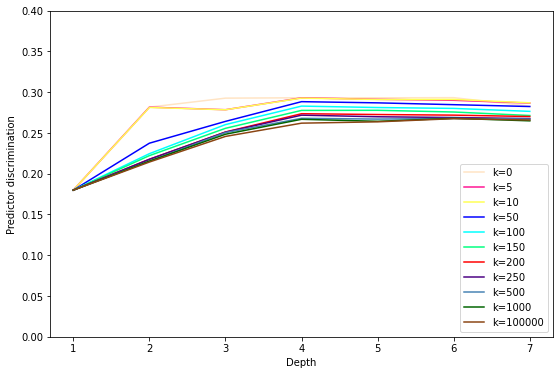

In [5]:
utils.plot_mean("depth", "discrimination_train_pred", result, 0, 0.4, "Depth", "Predictor discrimination", "Depth_Predictor_discrimination_train")

<Figure size 648x432 with 0 Axes>

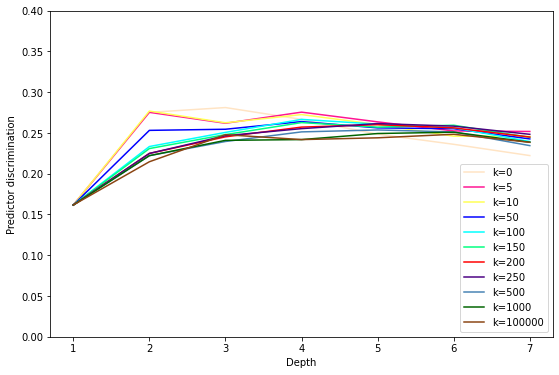

In [6]:
utils.plot_mean("depth", "discrimination_test", result, 0, 0.4, "Depth", "Predictor discrimination", "Depth_Predictor_discrimination_test")

<Figure size 648x432 with 0 Axes>

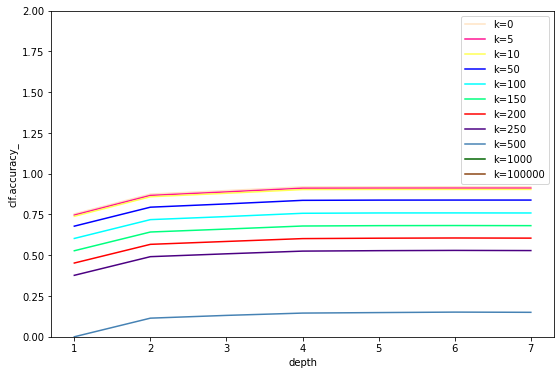

In [7]:
utils.plot_mean("depth", "clf.accuracy_", result, 0, 2)

<Figure size 648x432 with 0 Axes>

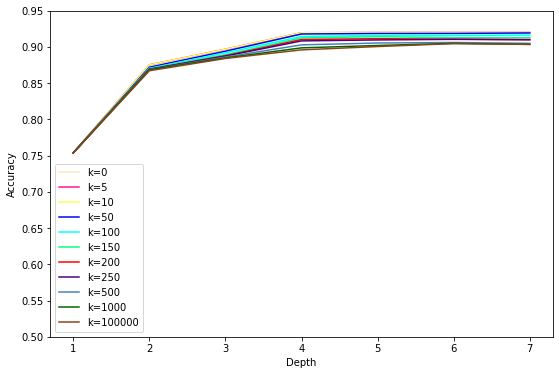

In [8]:
utils.plot_mean("depth", "accuracy_pred", result, 0.5, 0.95, "Depth", "Accuracy", "Depth_Accuracy_train")

<Figure size 648x432 with 0 Axes>

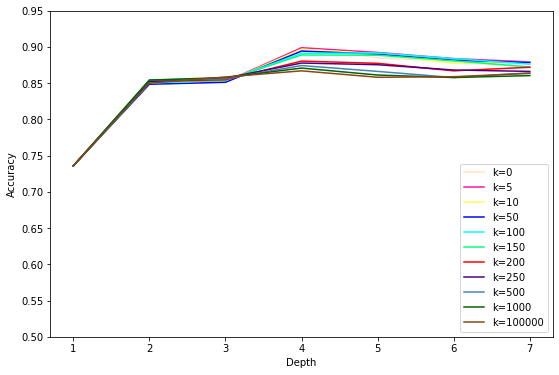

In [9]:
utils.plot_mean("depth", "accuracy_test", result, 0.5, 0.95, "Depth", "Accuracy", "Depth_Accuracy_test")

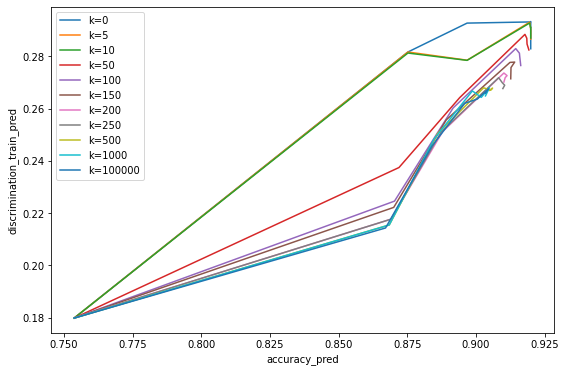

In [10]:
utils.plot2("accuracy_pred", "discrimination_train_pred", result)

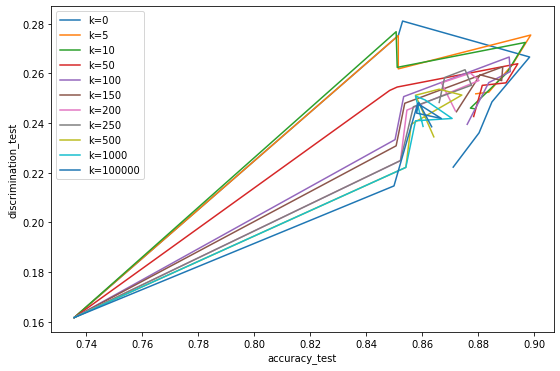

In [11]:
utils.plot2("accuracy_test", "discrimination_test", result)

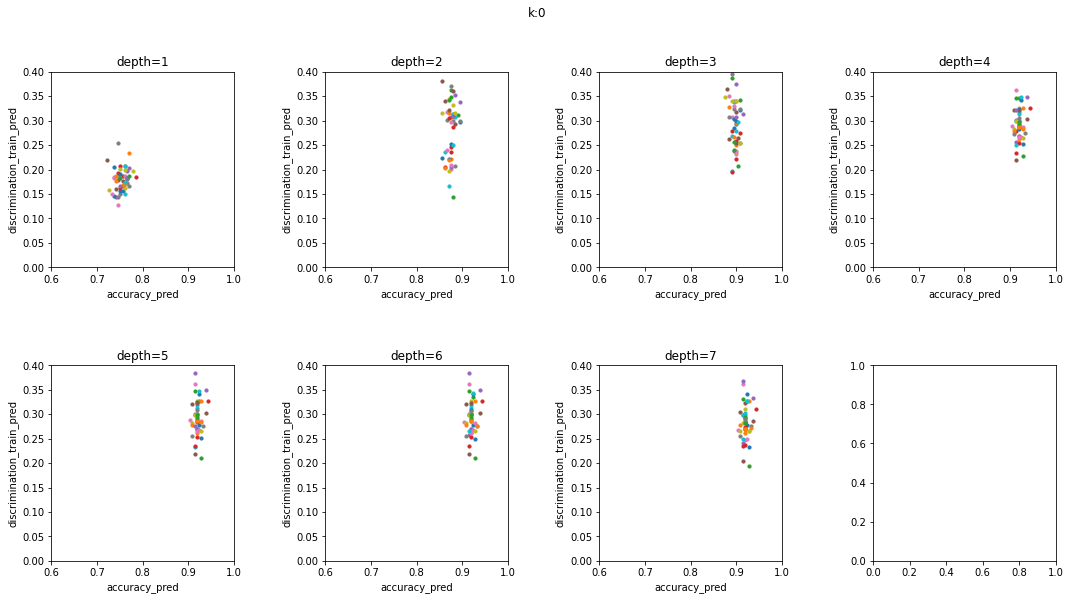

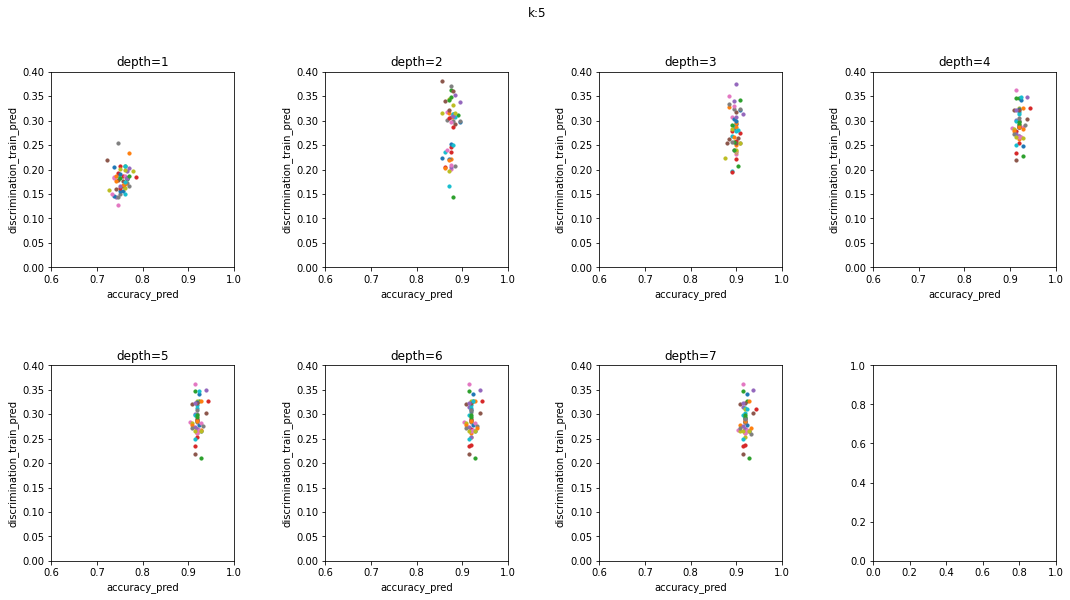

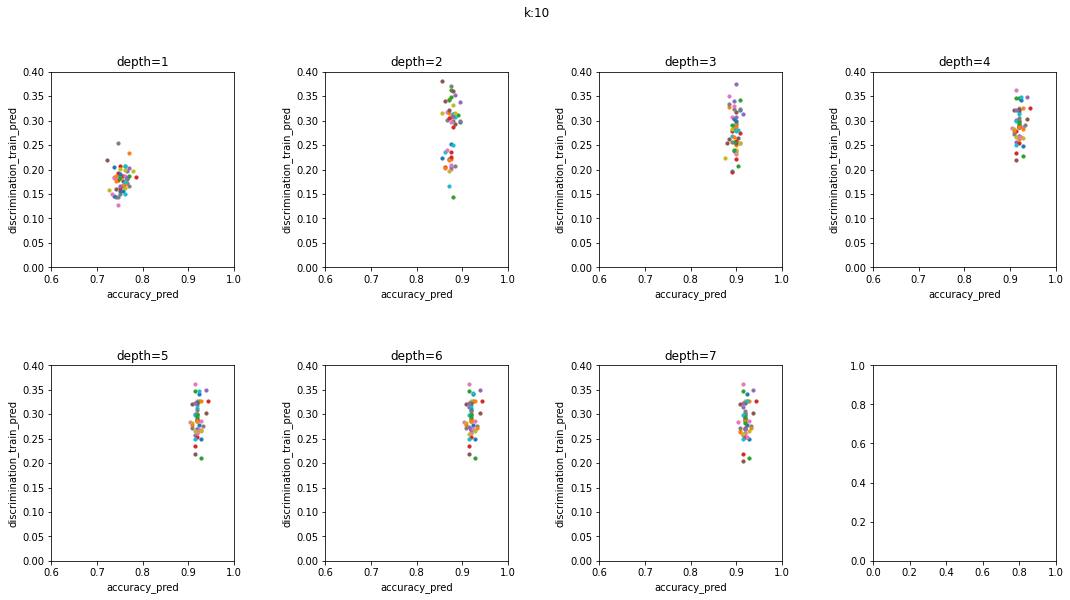

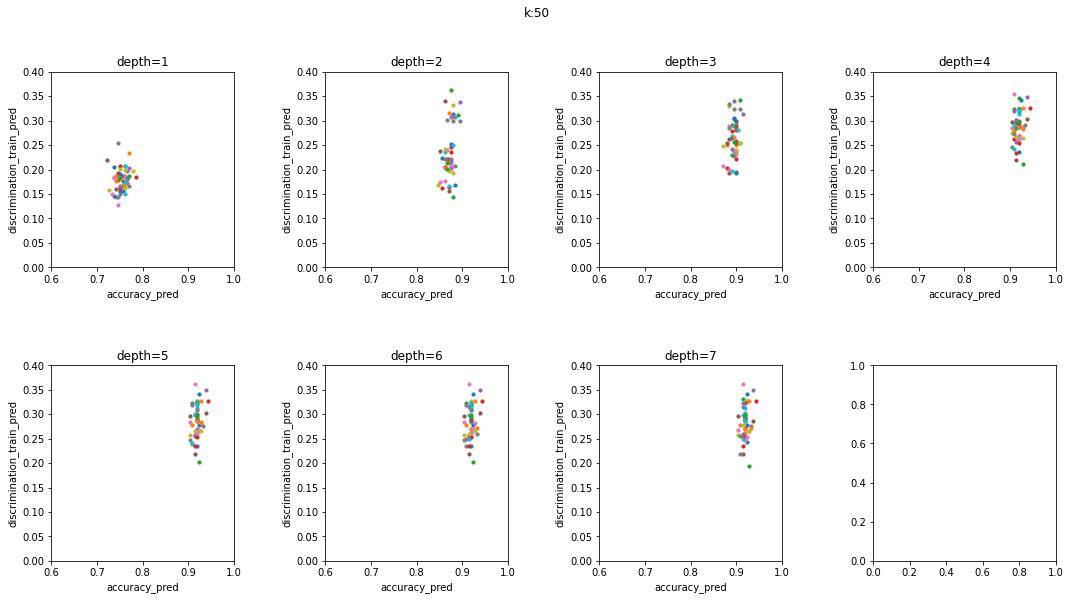

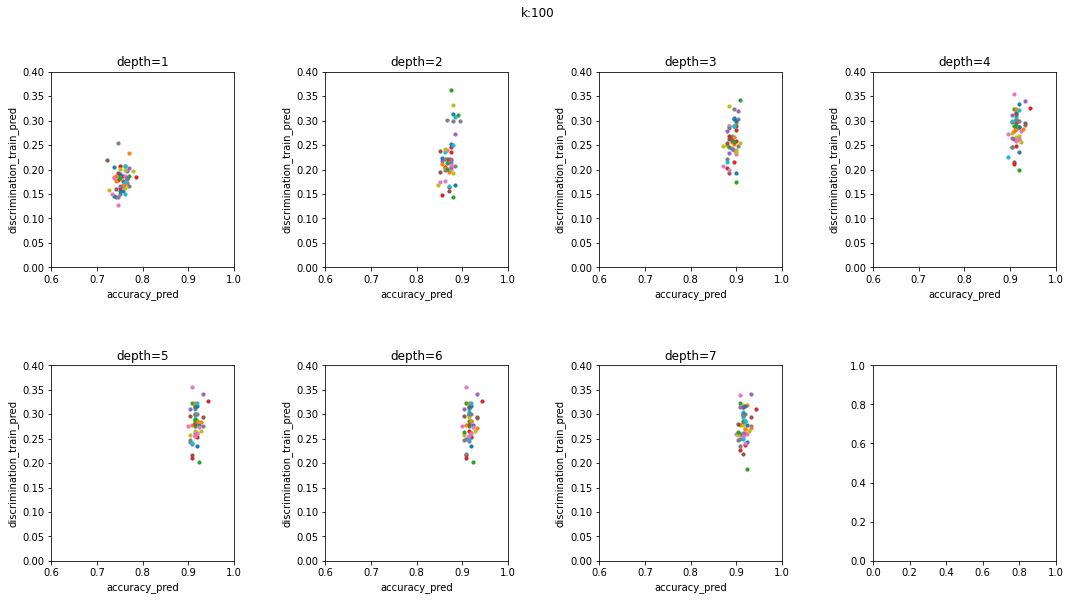

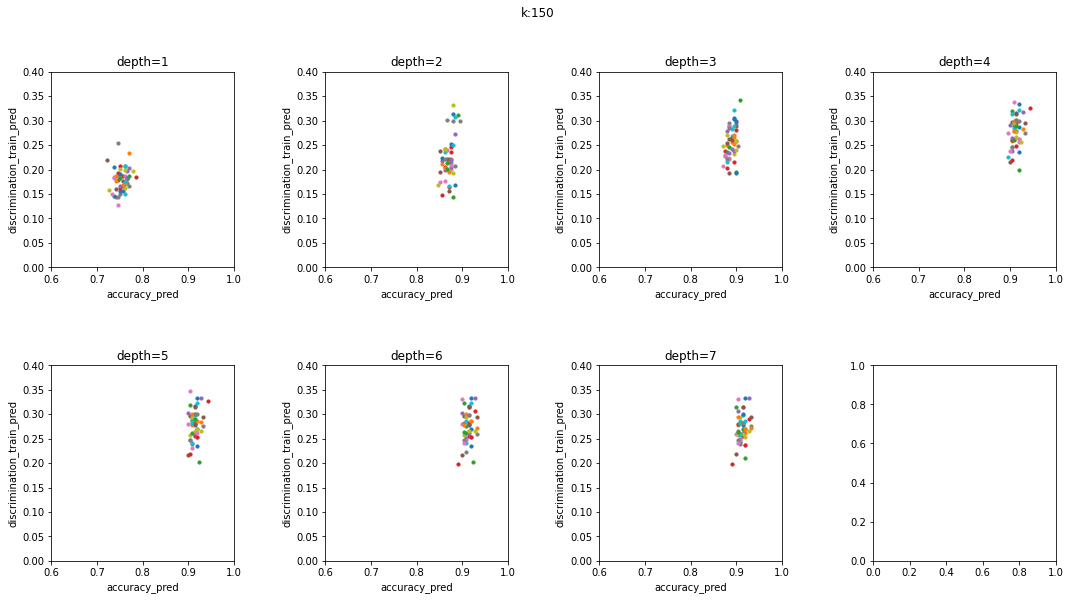

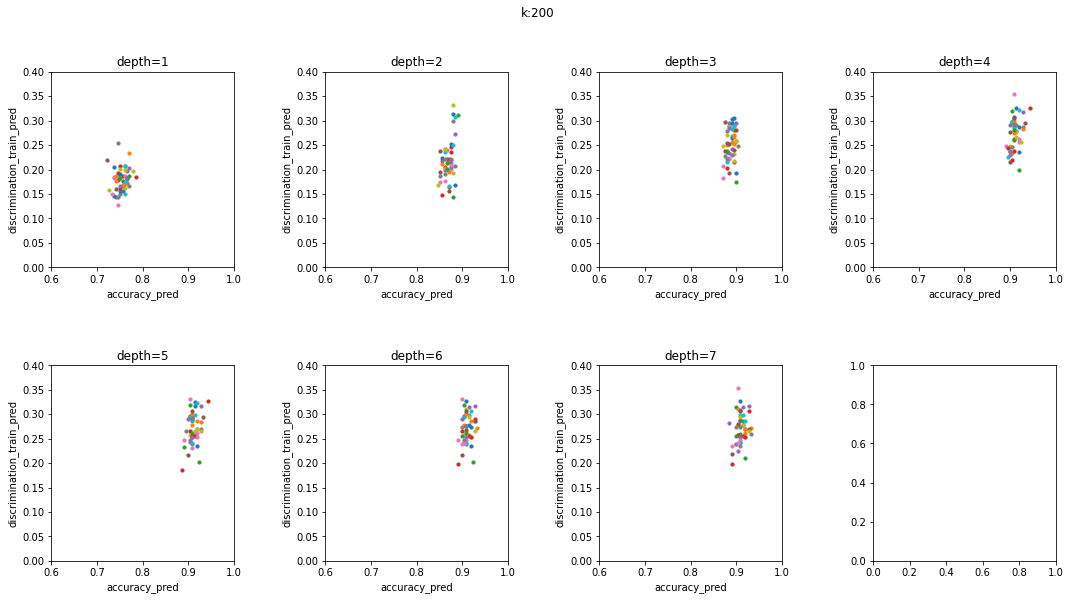

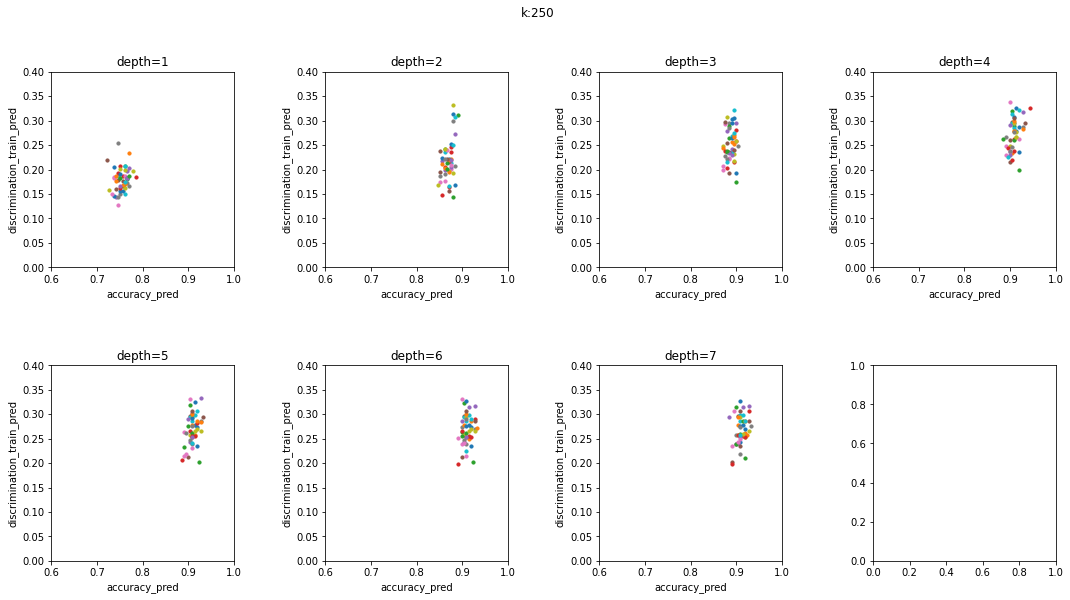

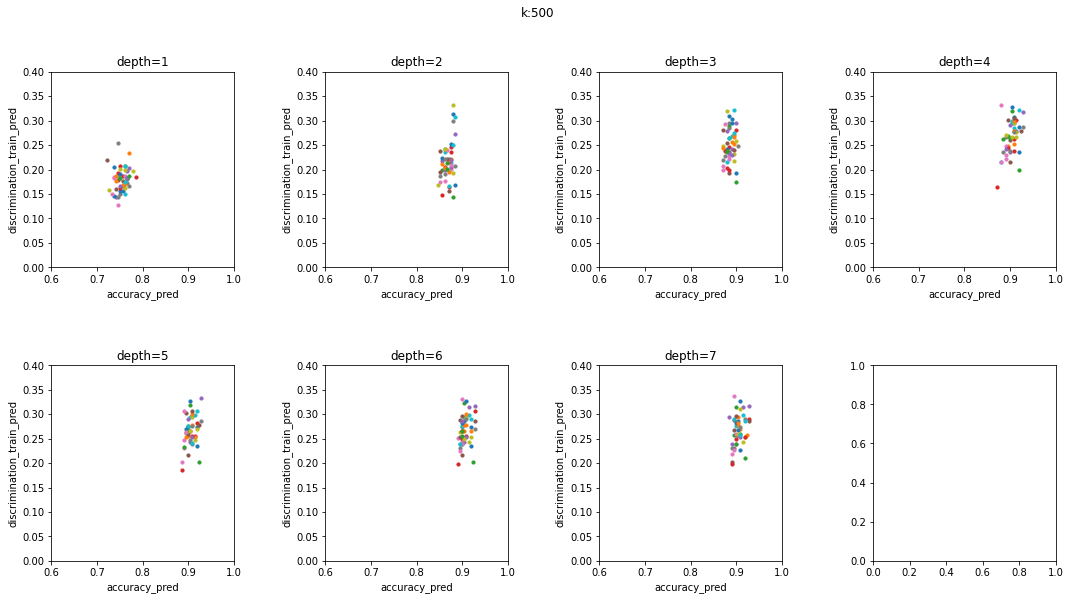

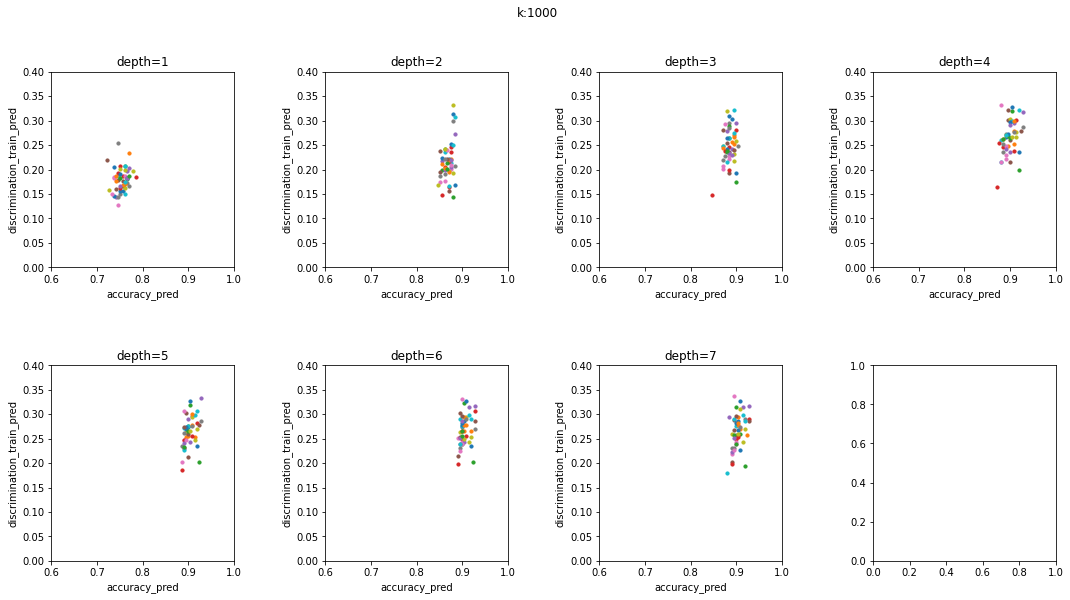

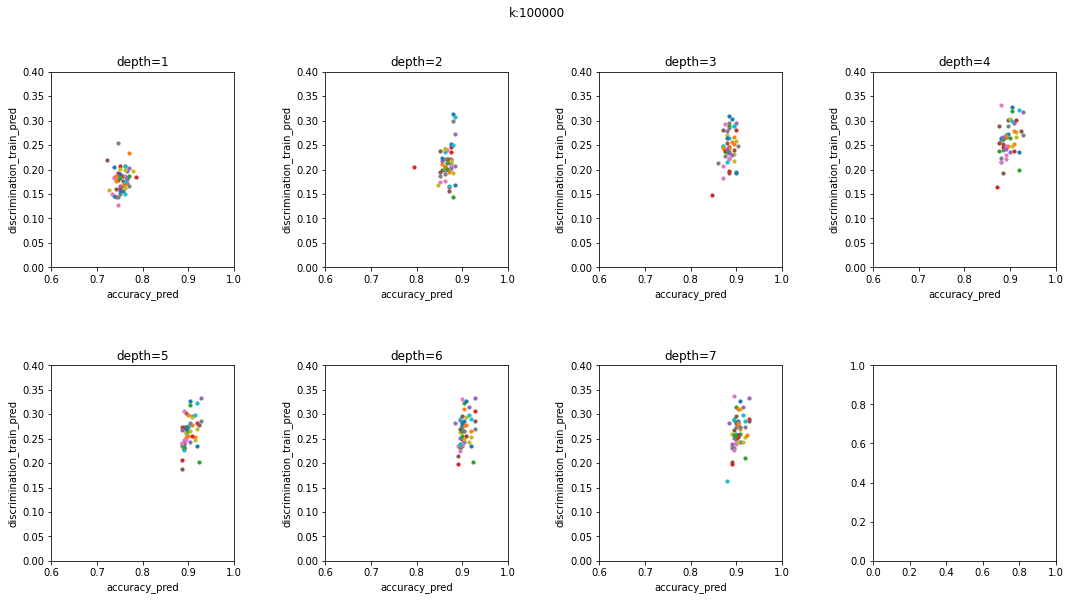

In [12]:
utils.plot_one_scatter_by_depth("accuracy_pred", "discrimination_train_pred", result, (0.6, 1), (0, 0.4))

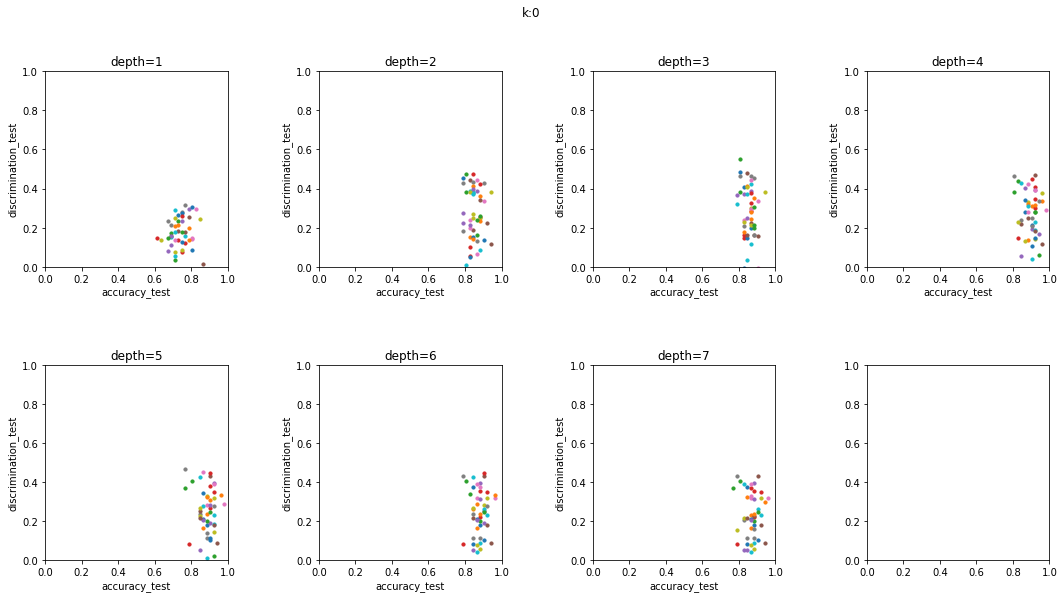

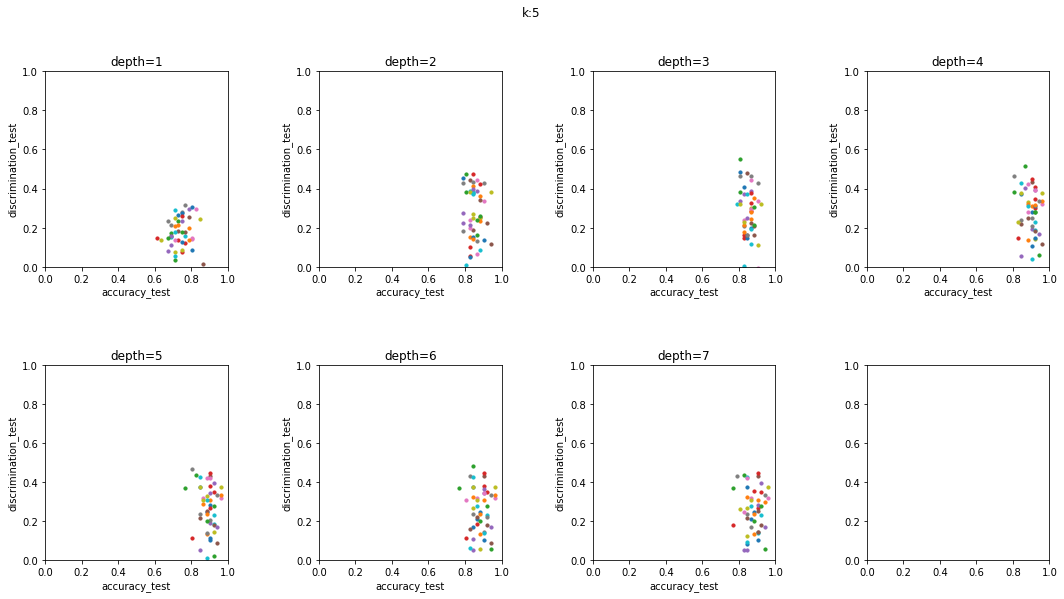

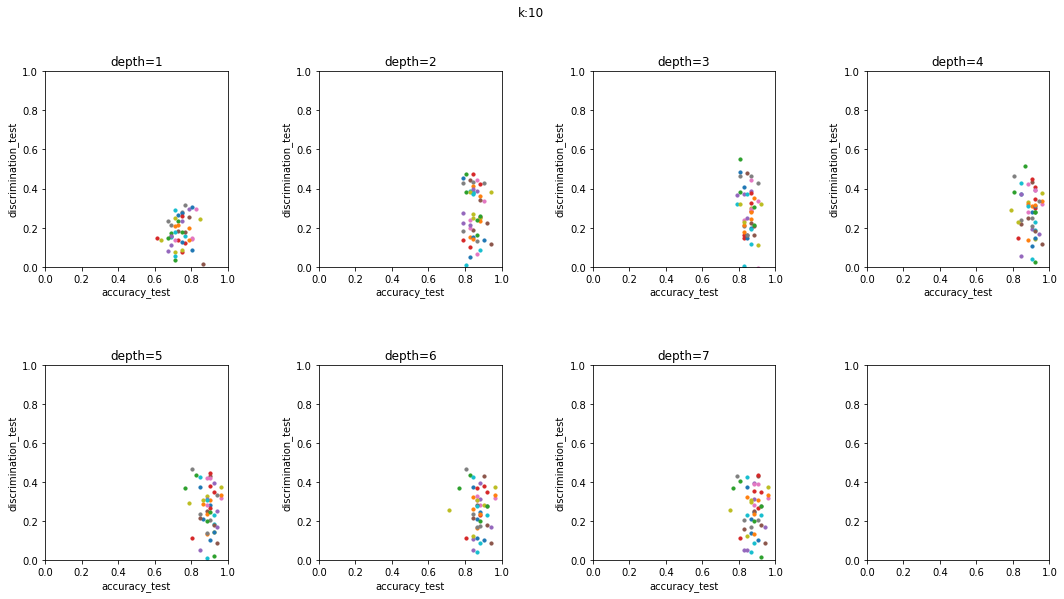

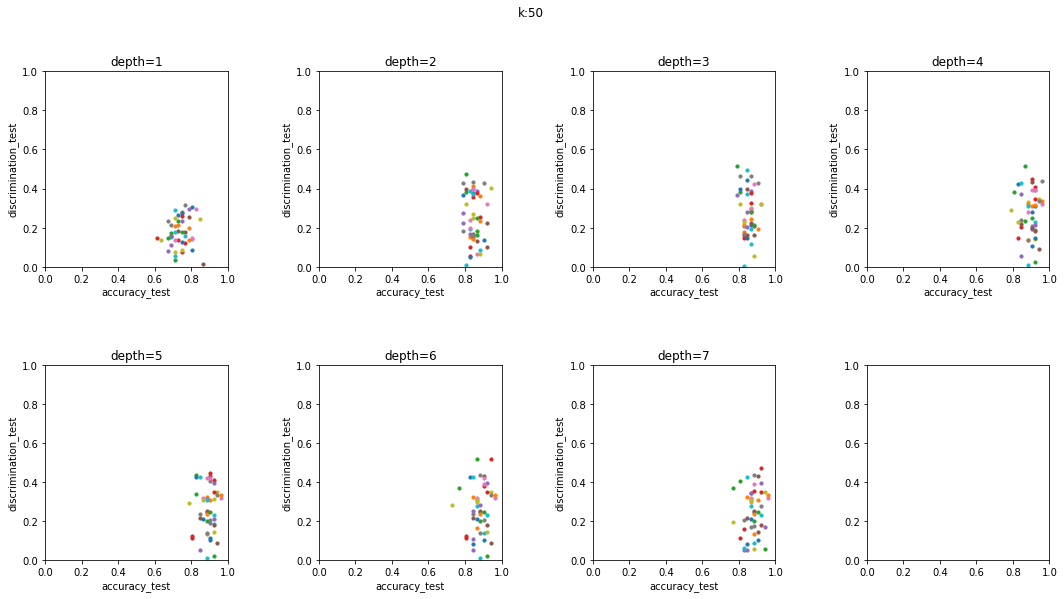

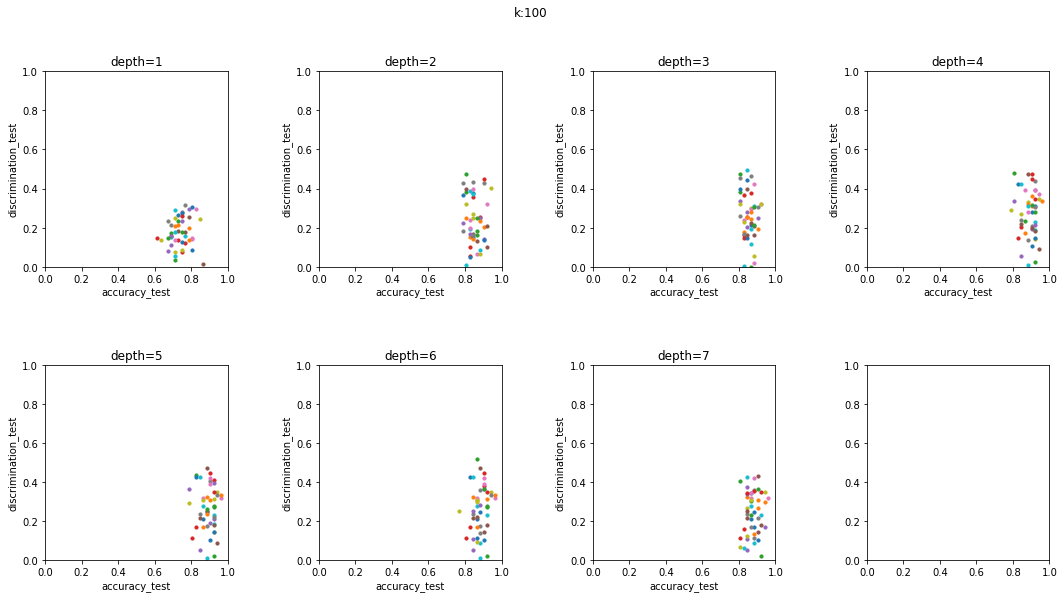

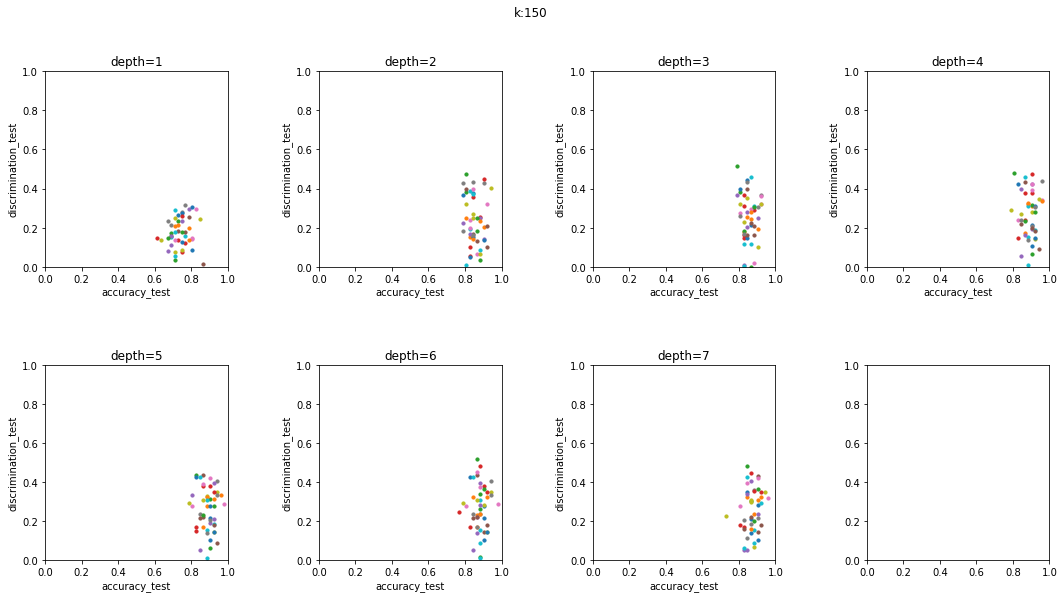

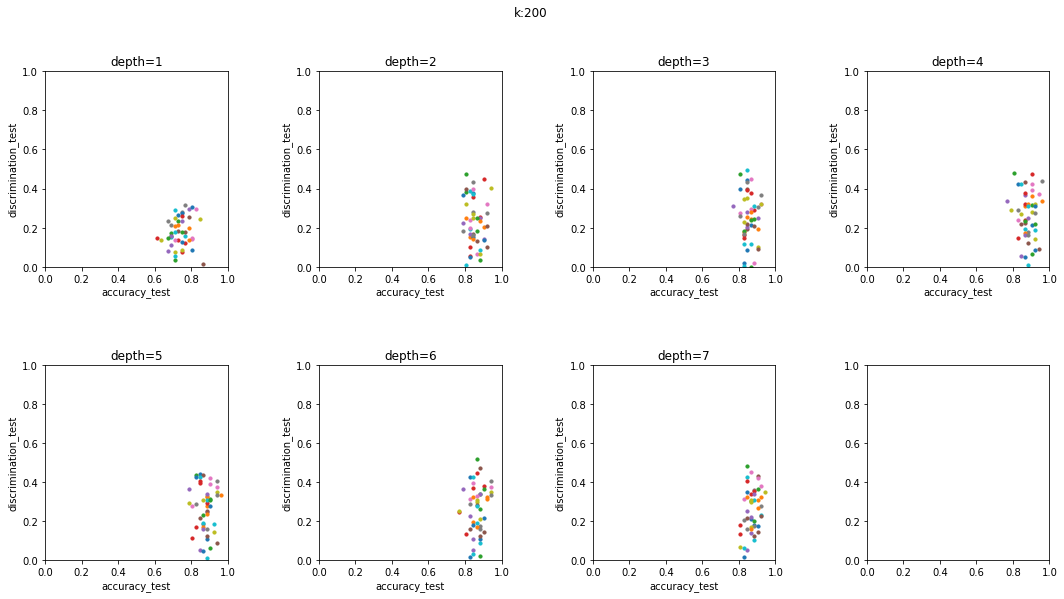

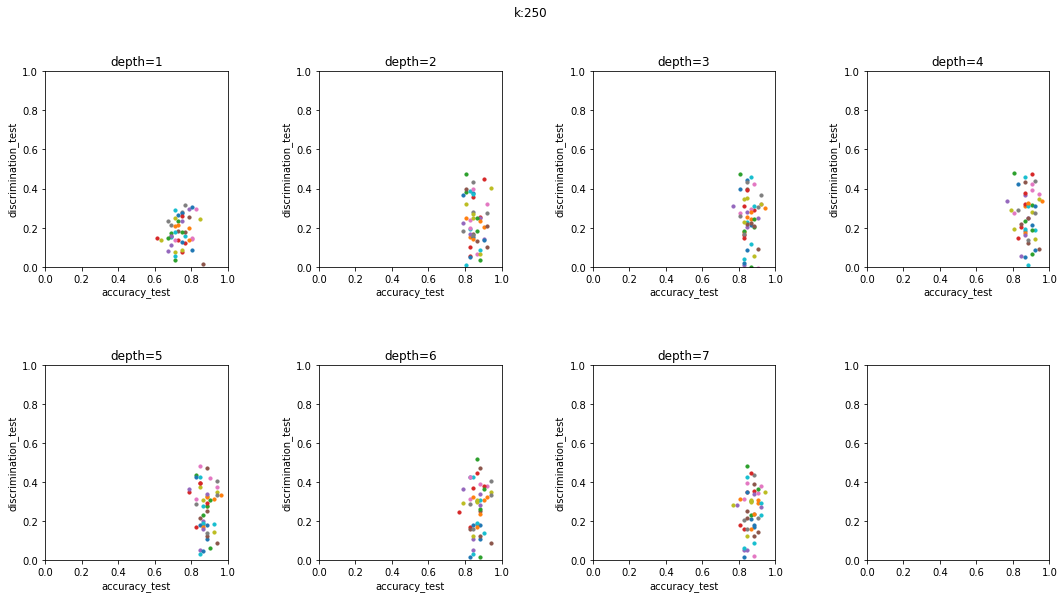

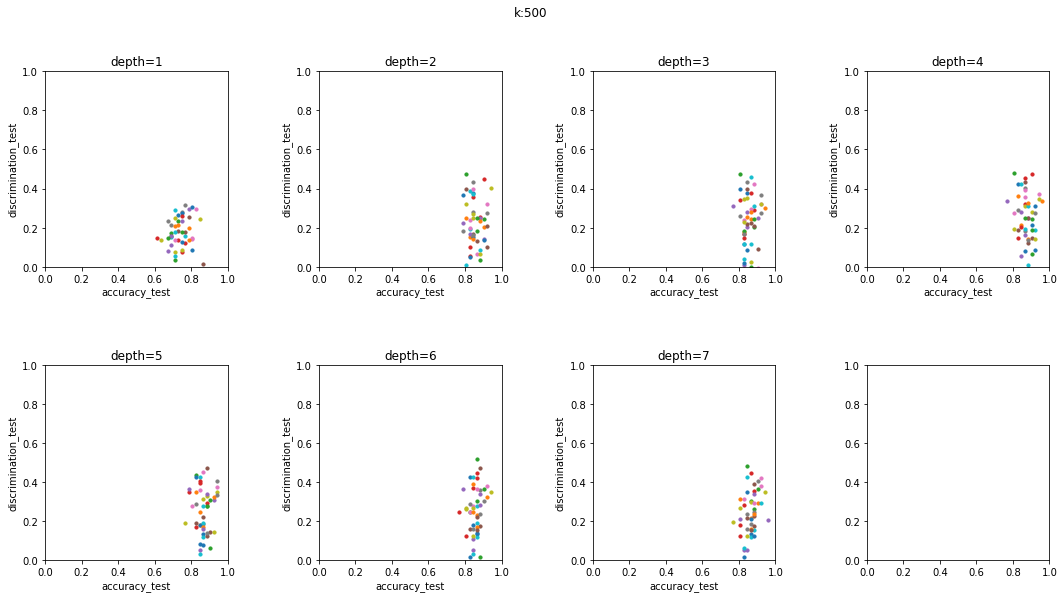

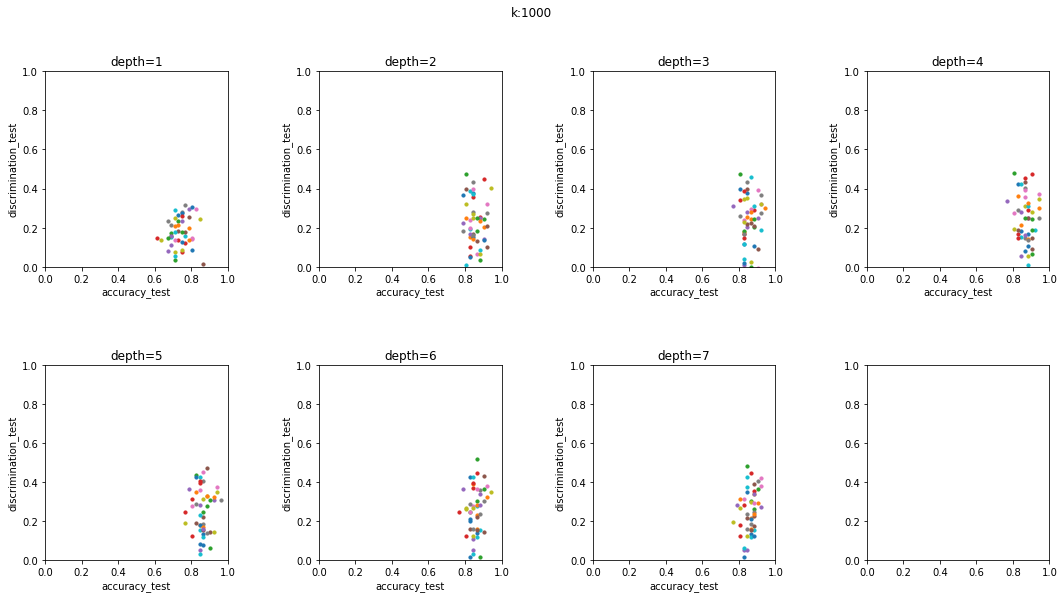

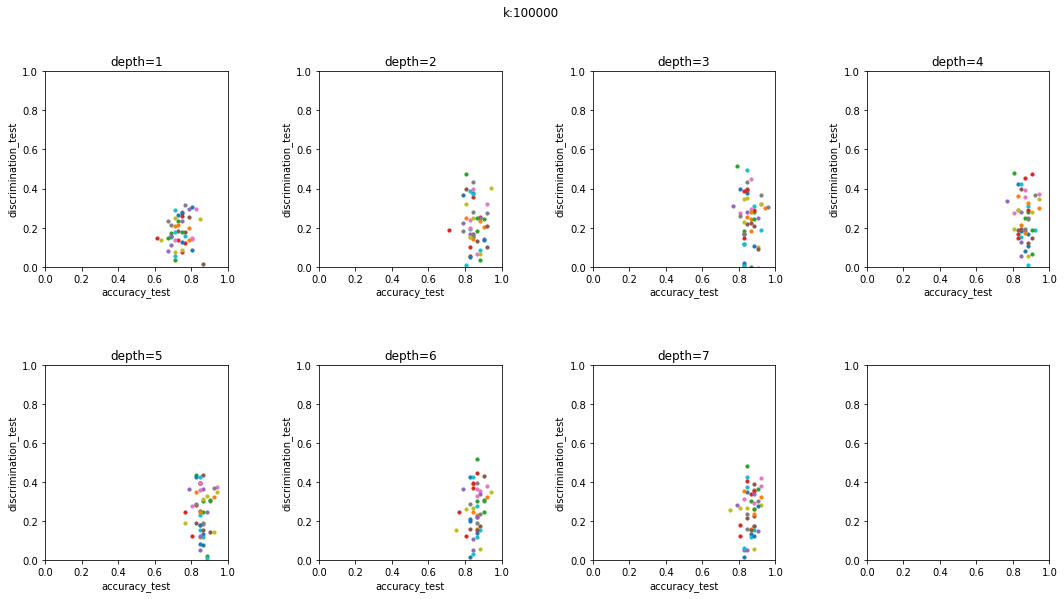

In [13]:
utils.plot_one_scatter_by_depth("accuracy_test", "discrimination_test", result, (0, 1), (0, 1))

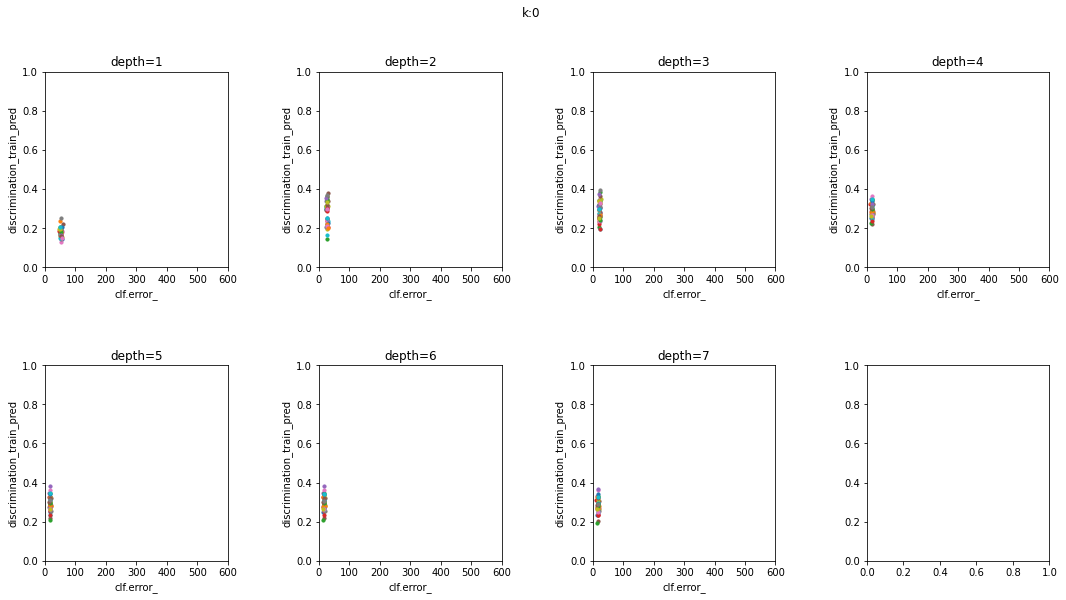

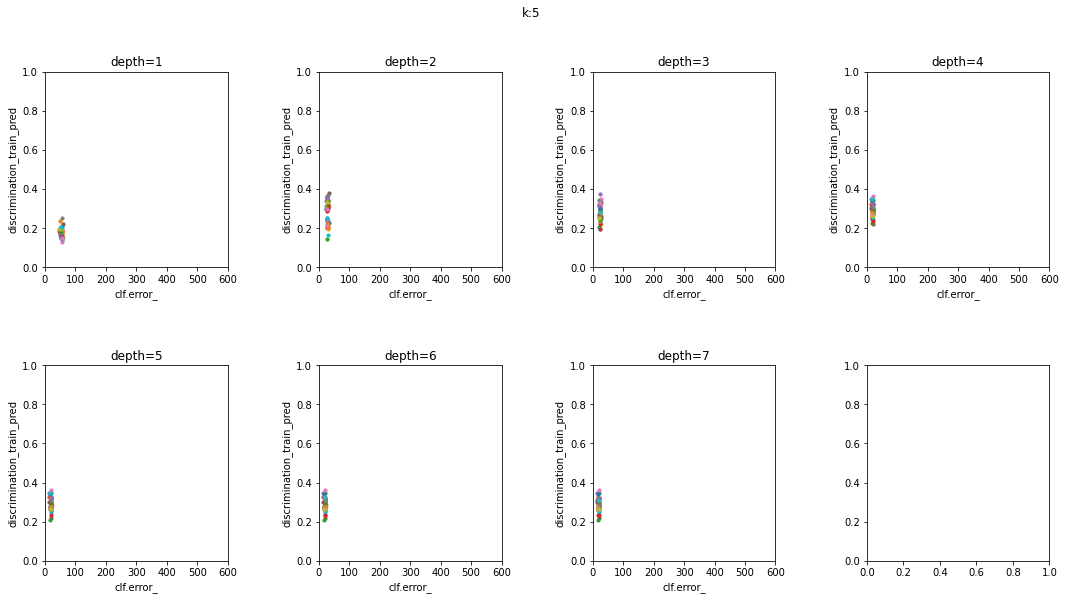

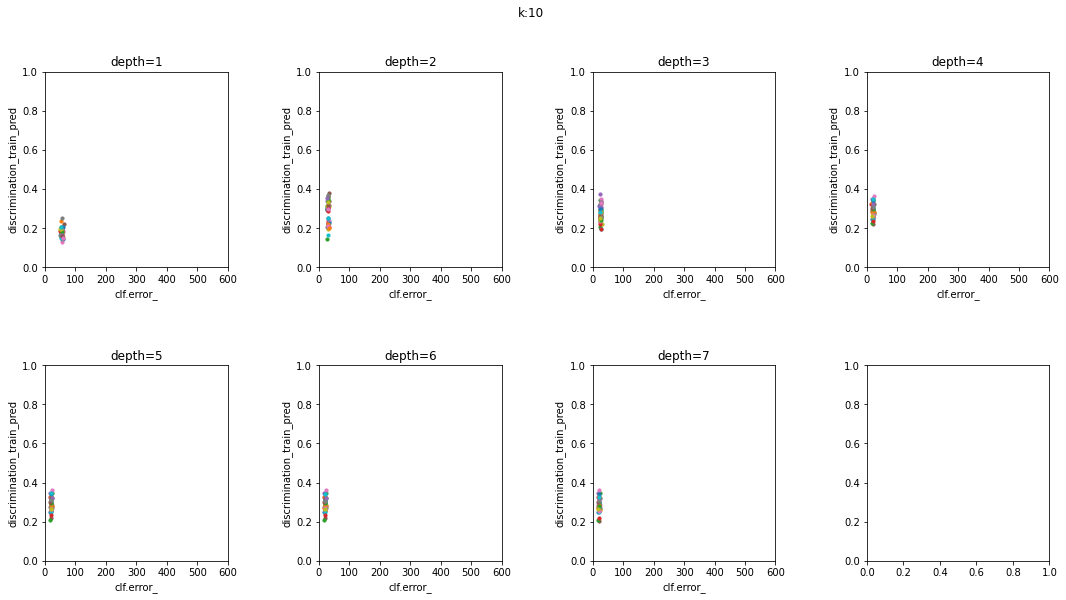

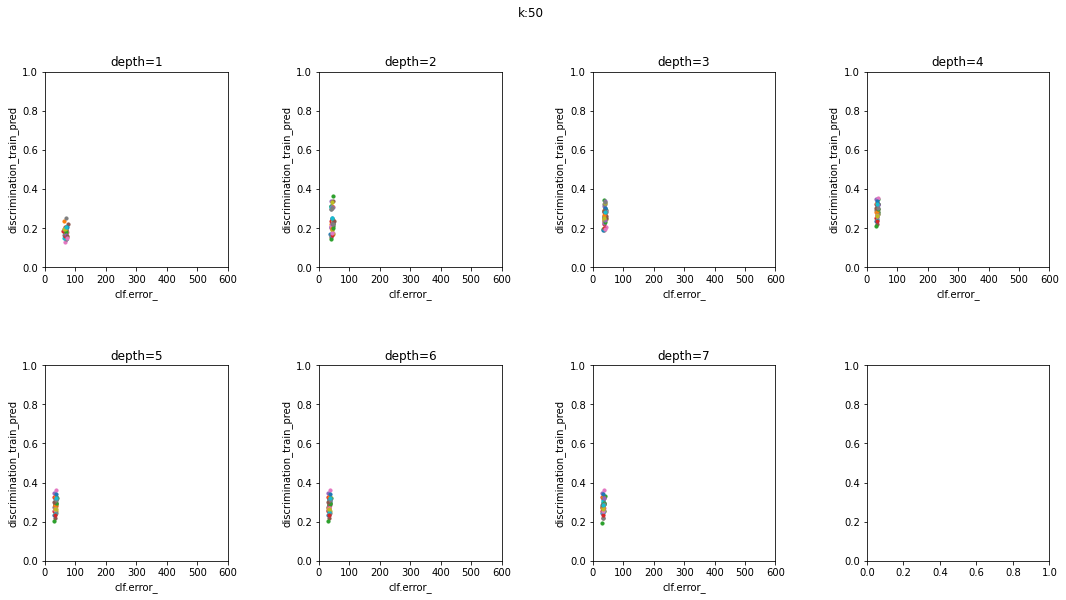

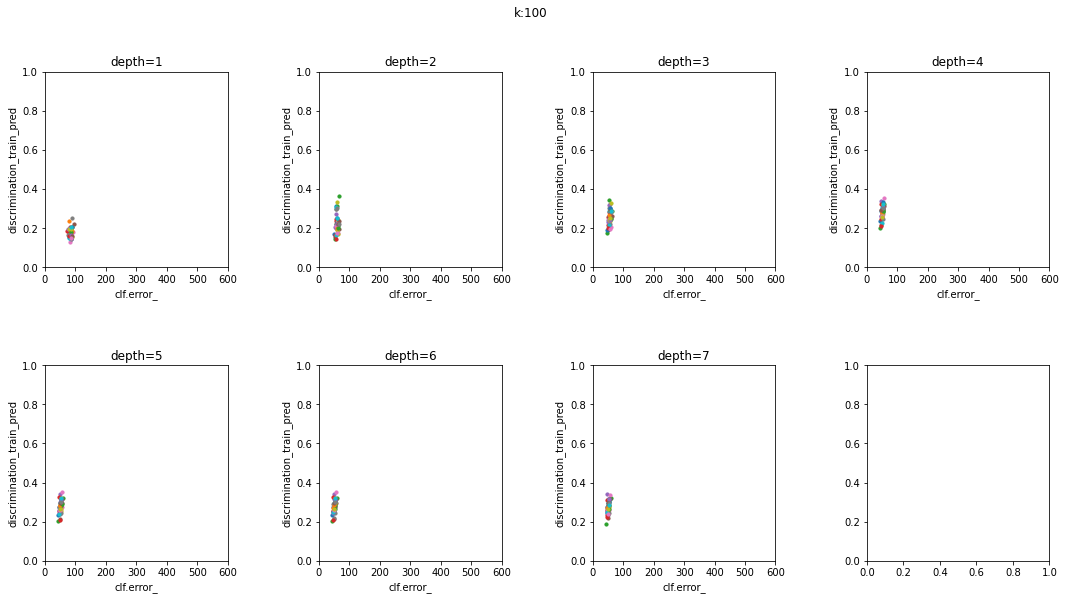

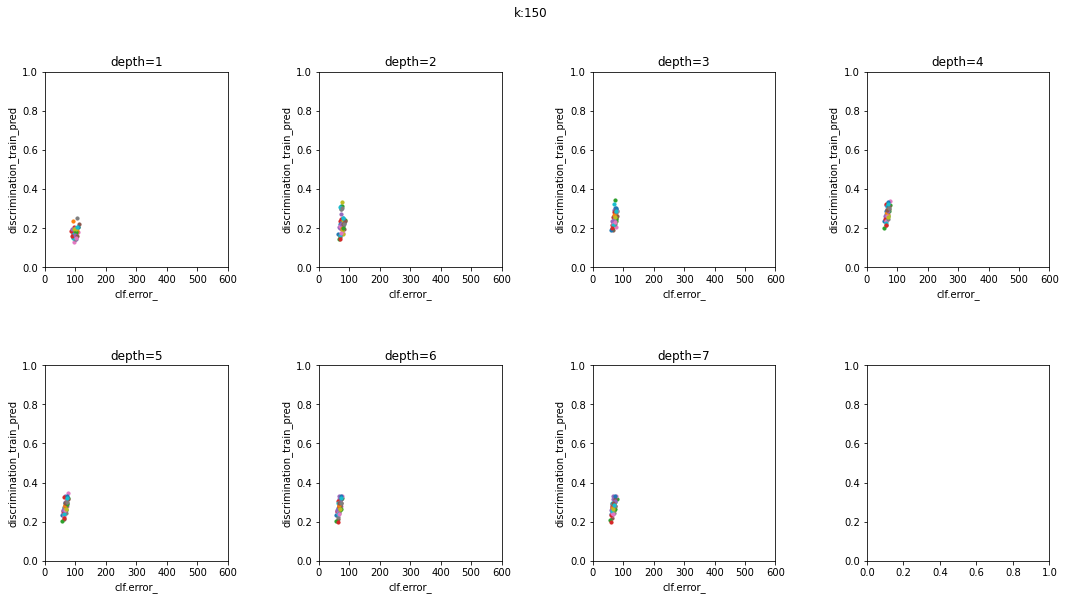

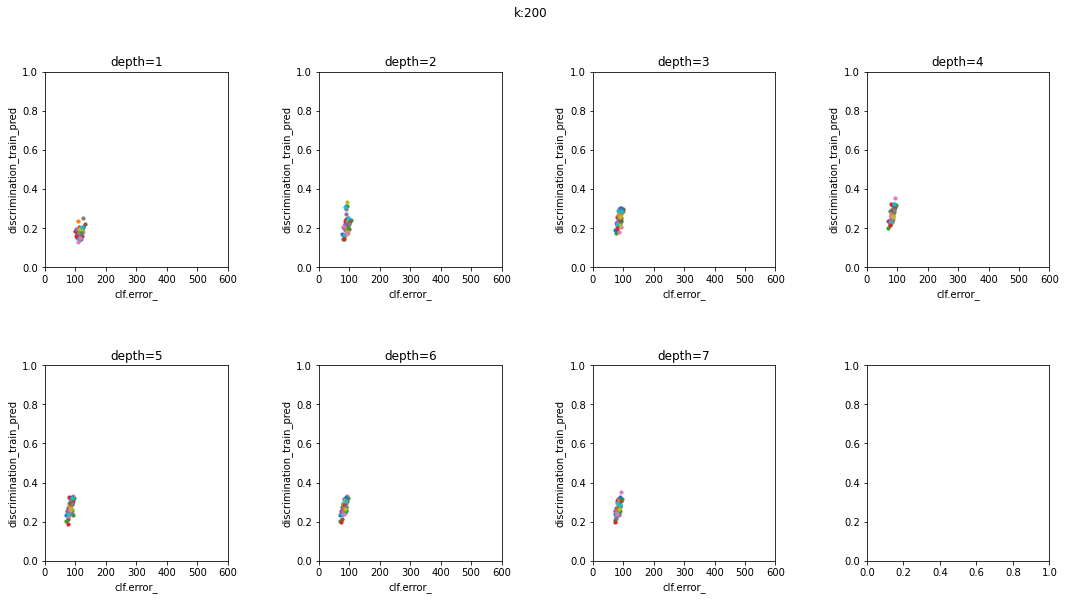

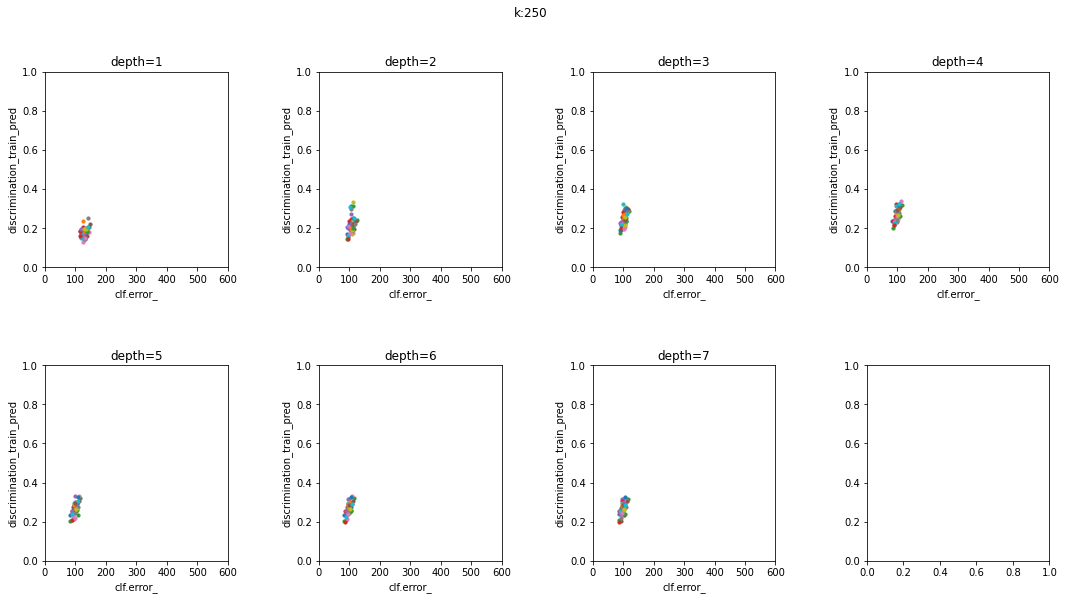

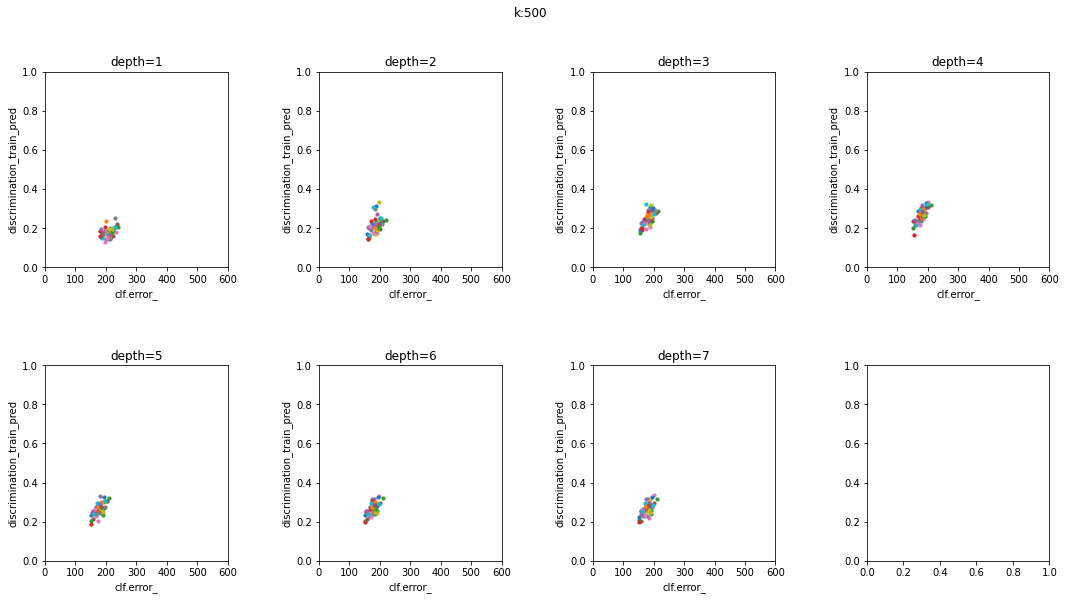

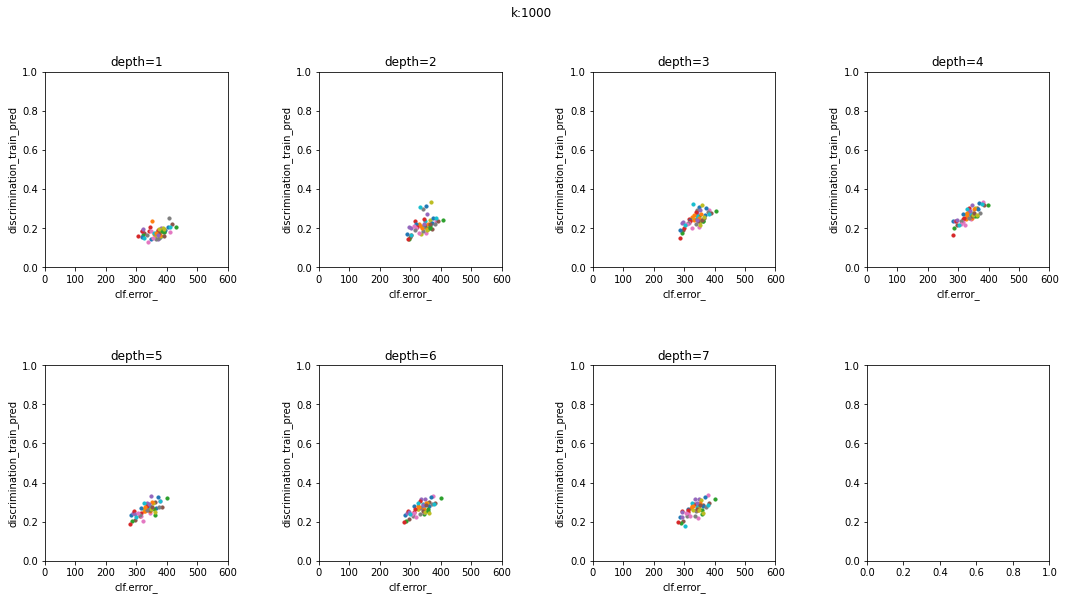

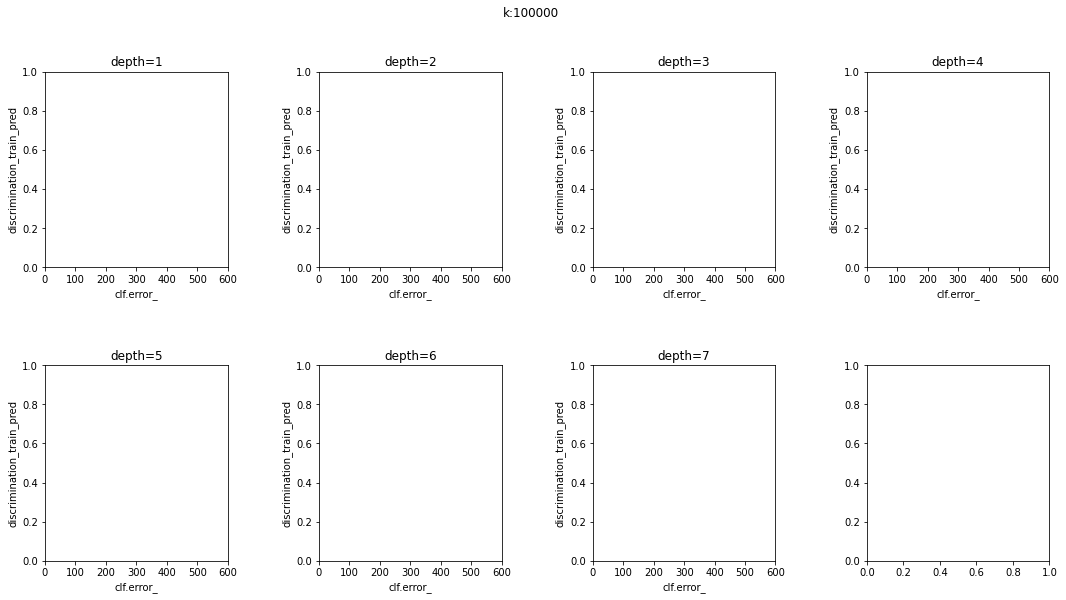

In [14]:
utils.plot_one_scatter_by_depth("clf.error_", "discrimination_train_pred", result, (0, 600), (0, 1))

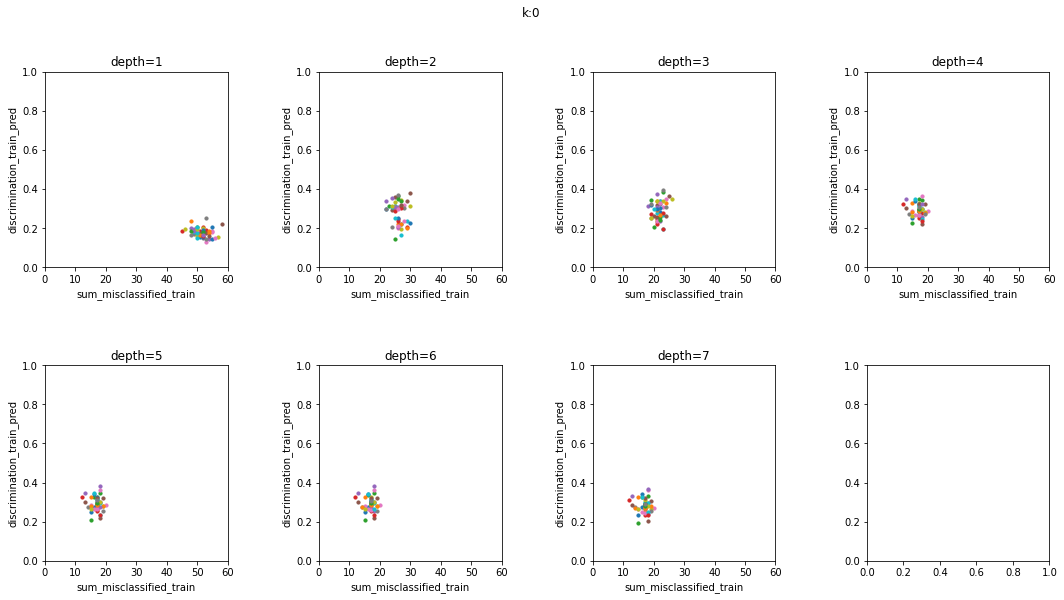

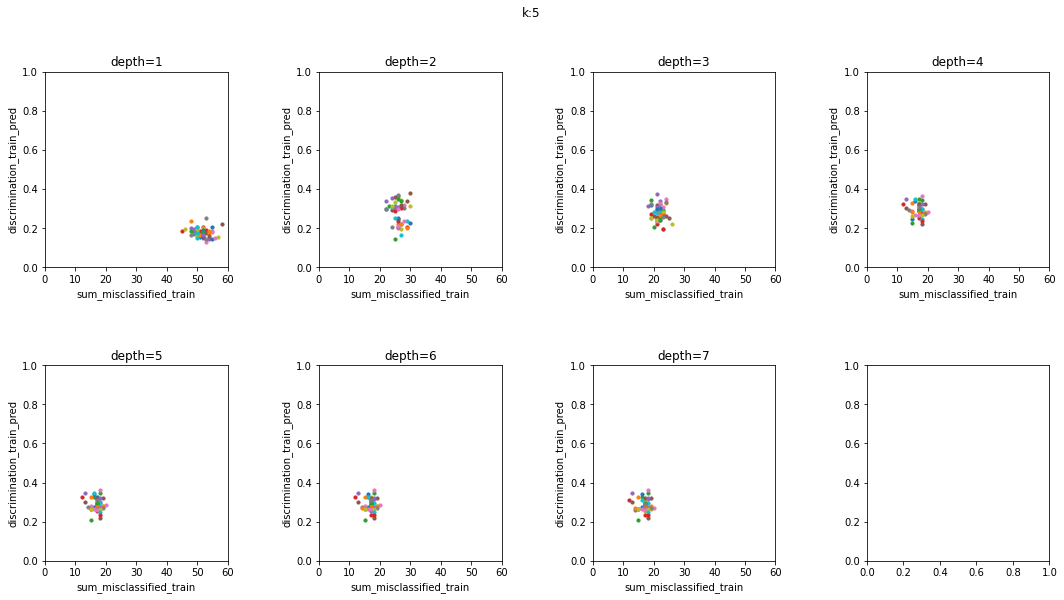

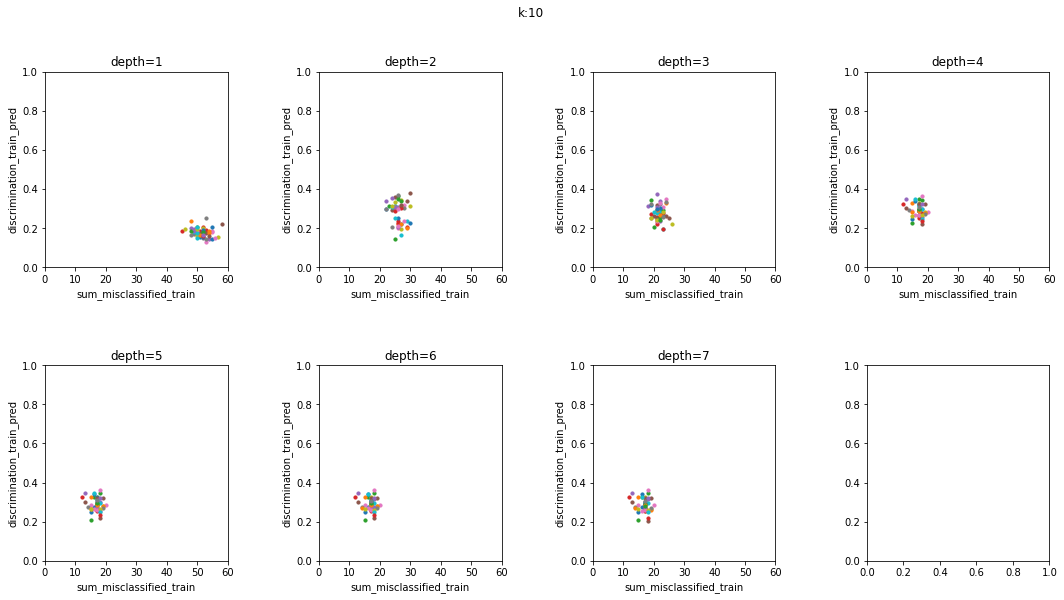

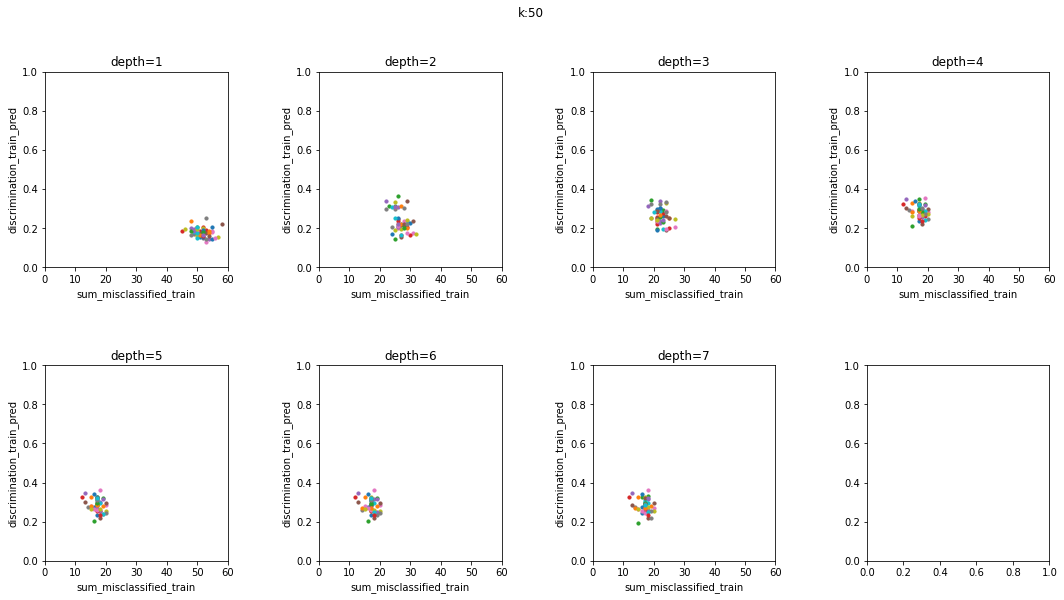

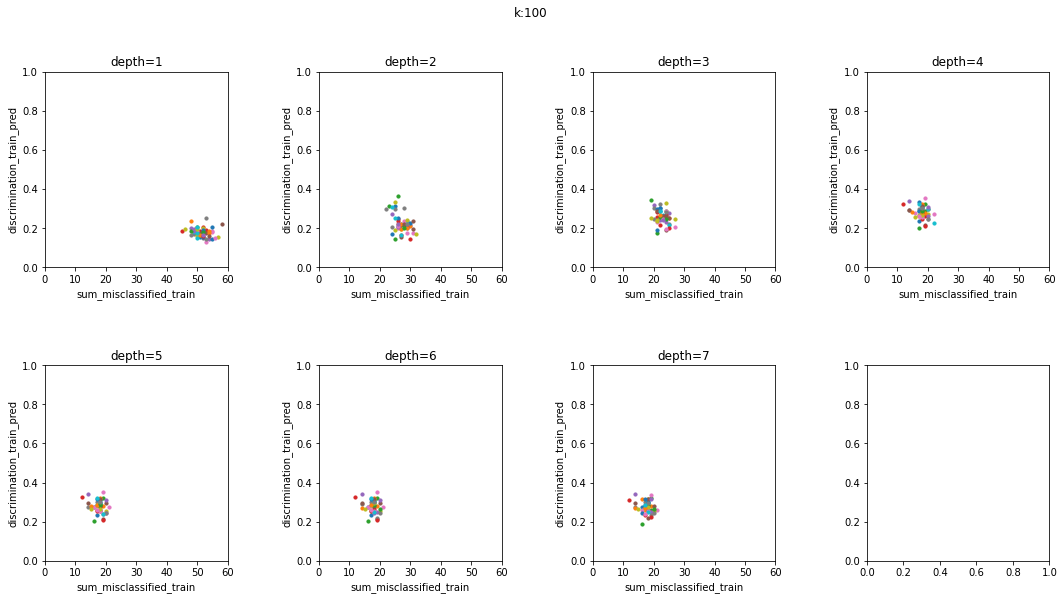

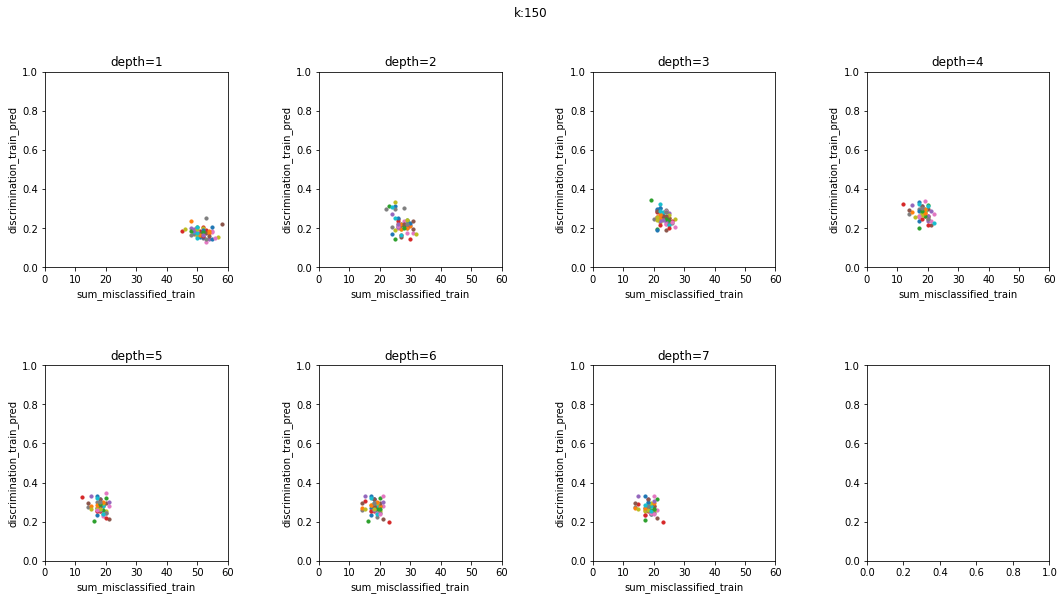

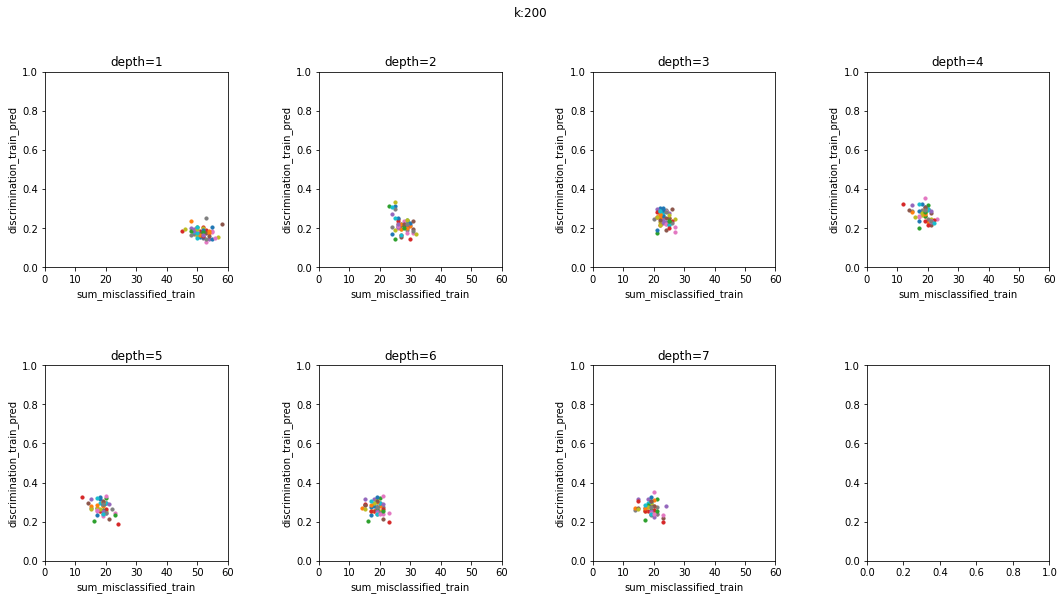

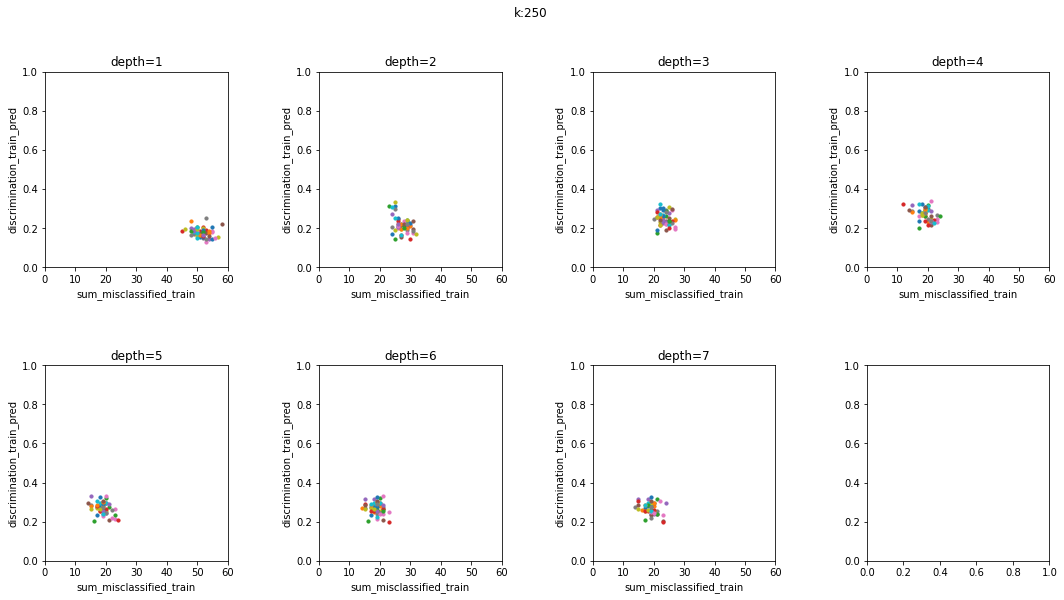

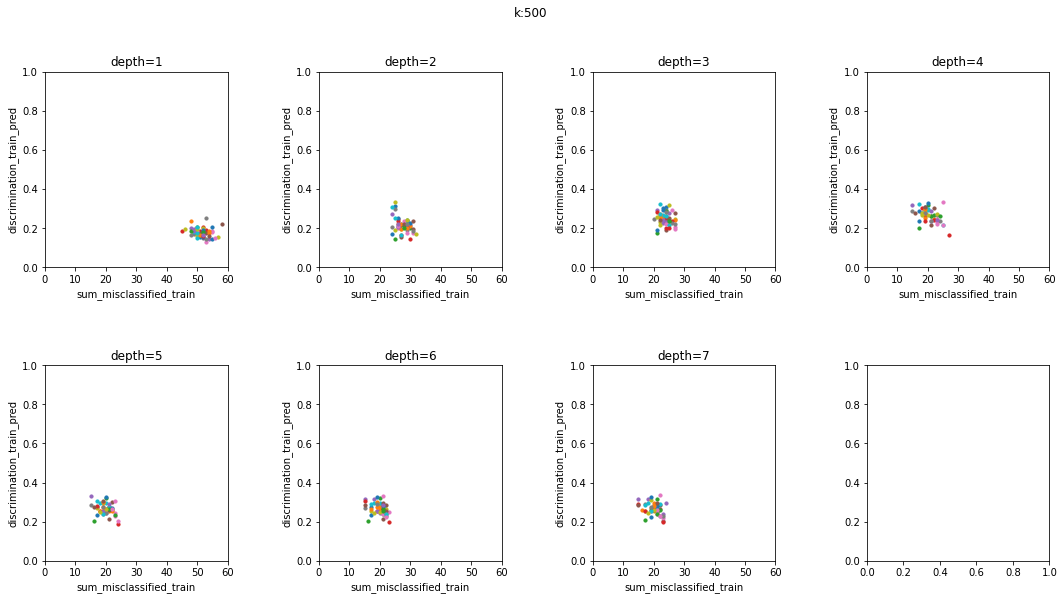

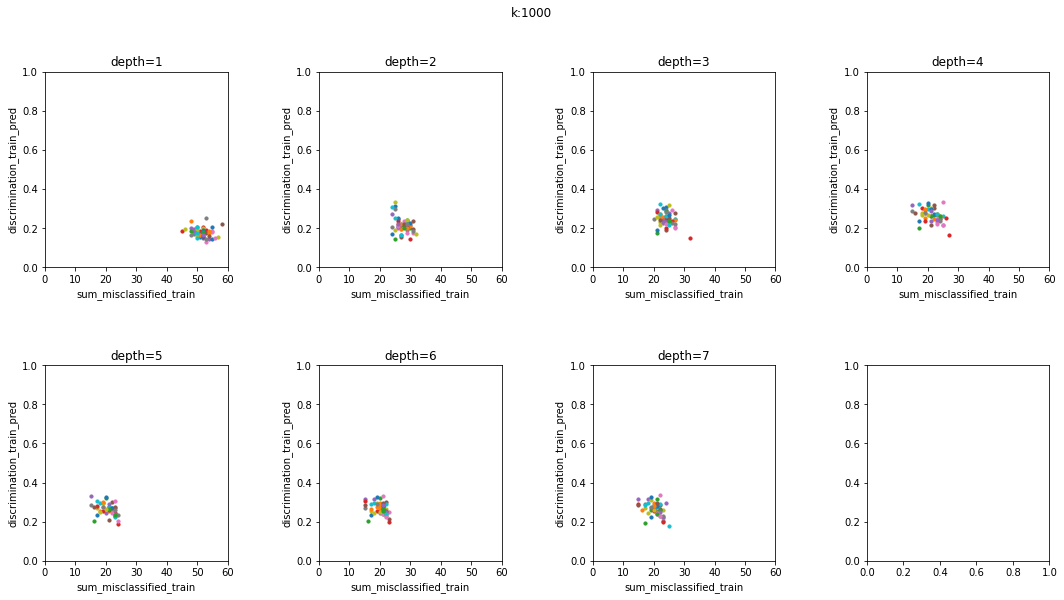

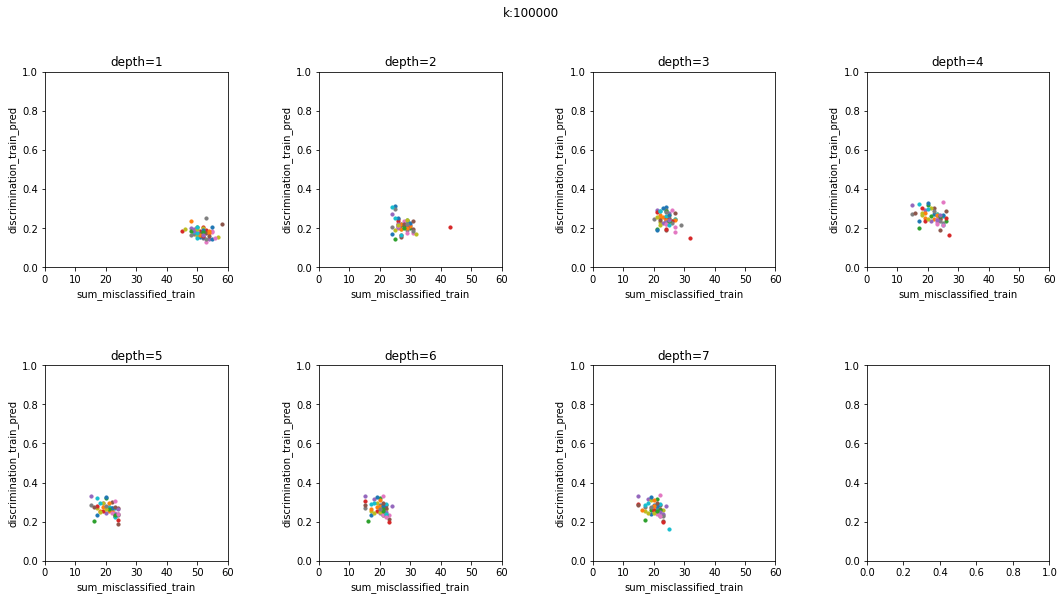

In [15]:
utils.plot_one_scatter_by_depth("sum_misclassified_train", "discrimination_train_pred", result, (0, 60), (0, 1))

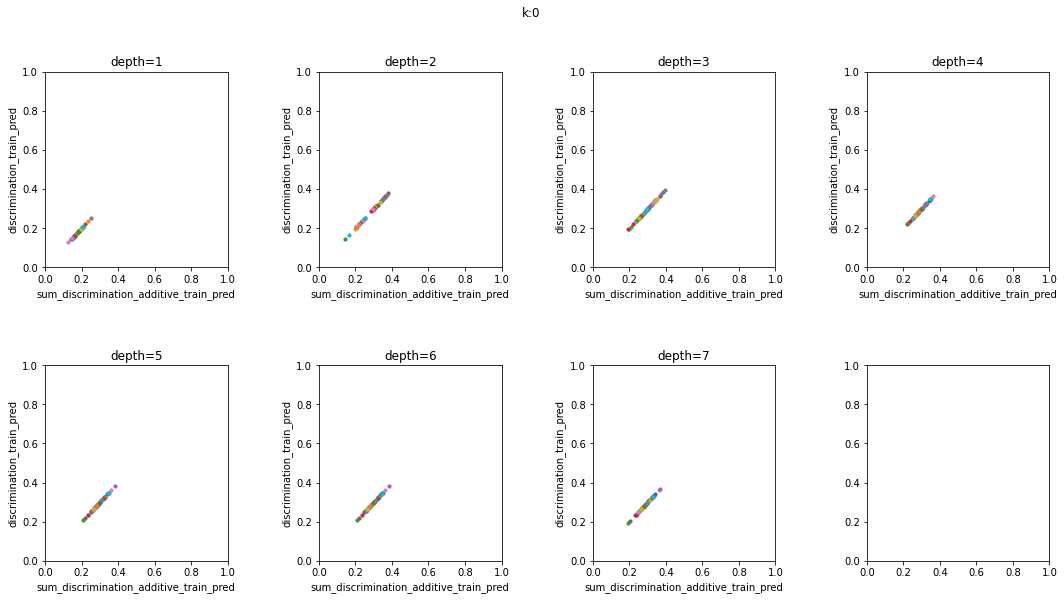

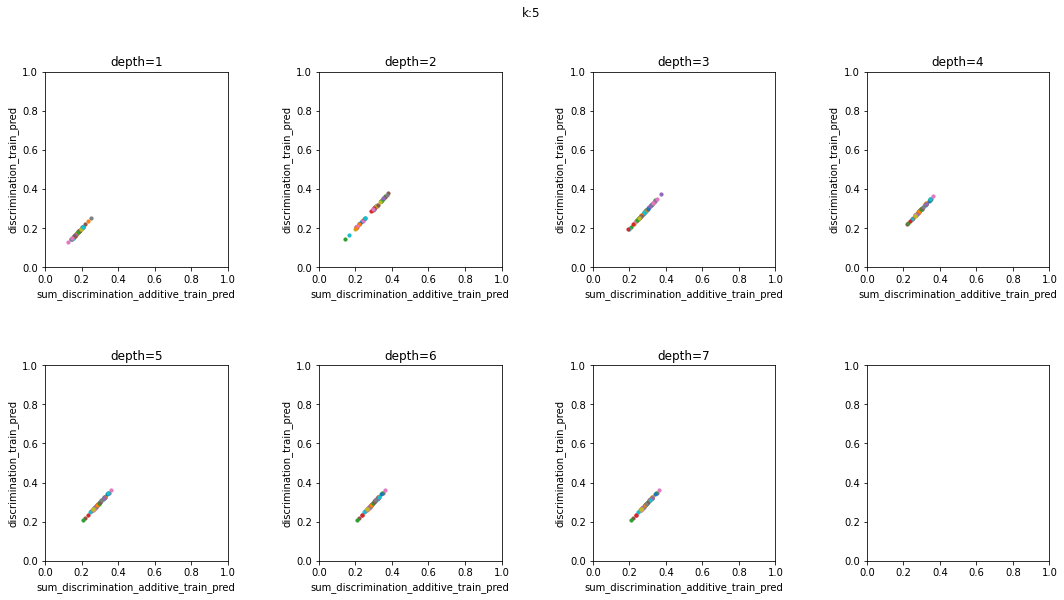

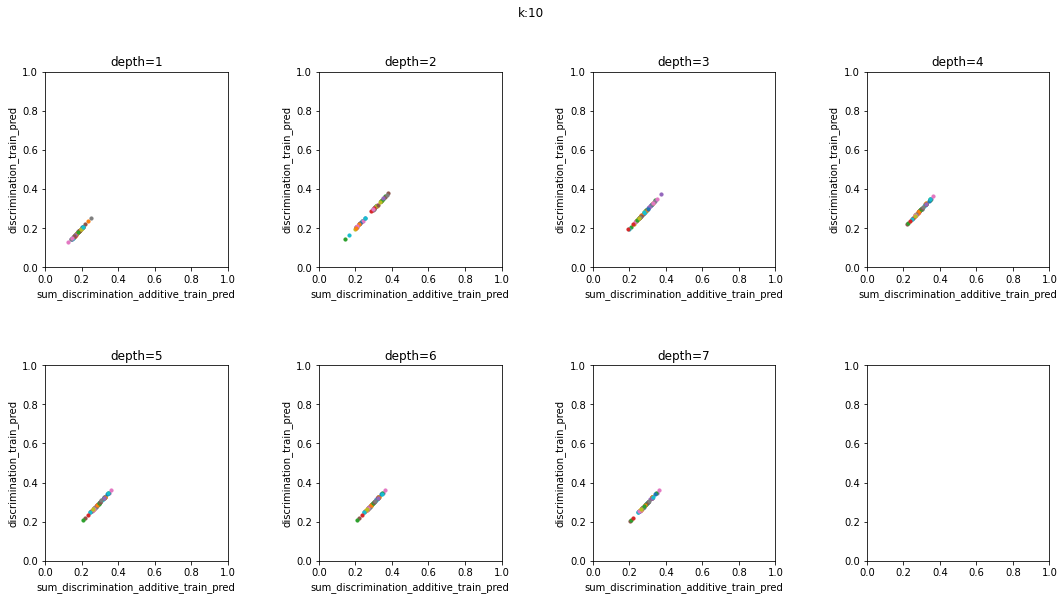

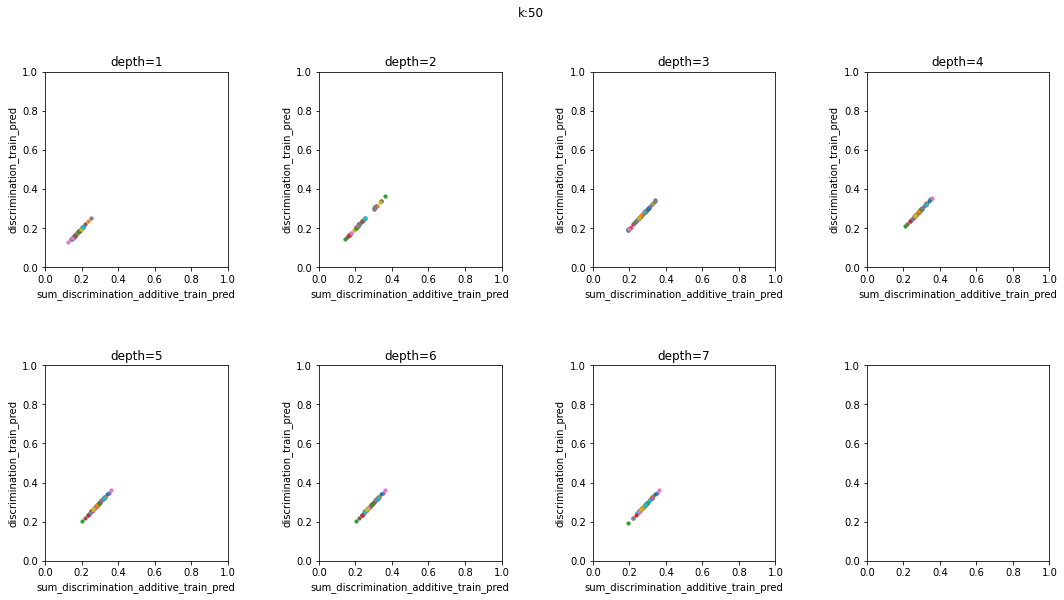

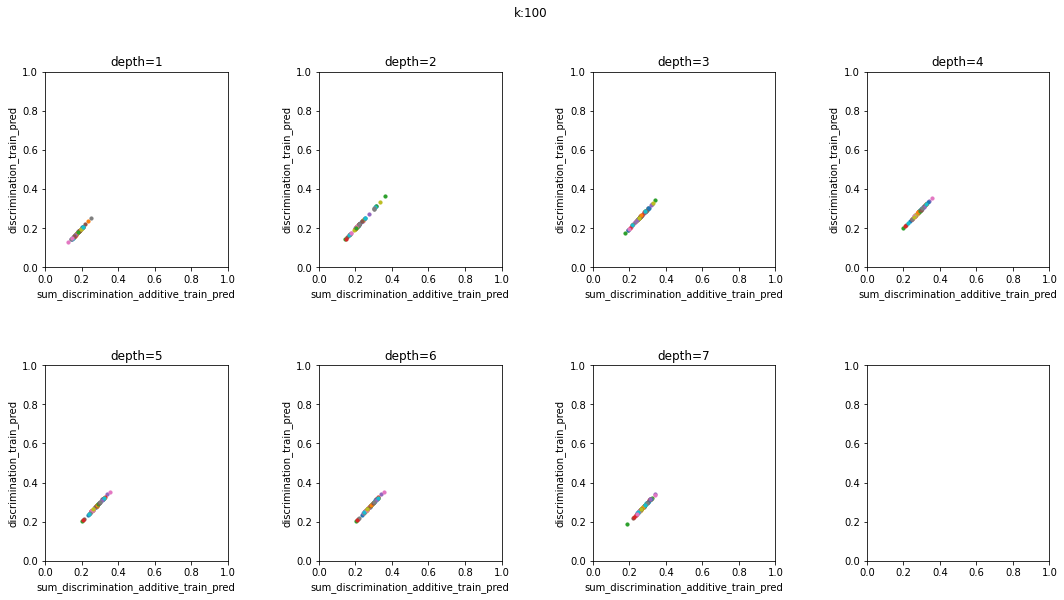

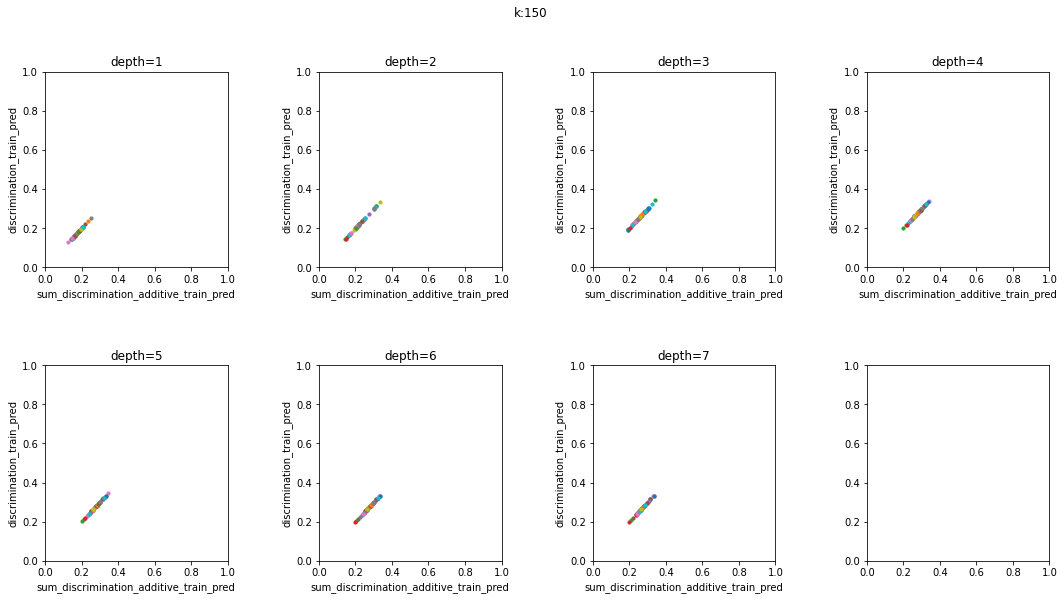

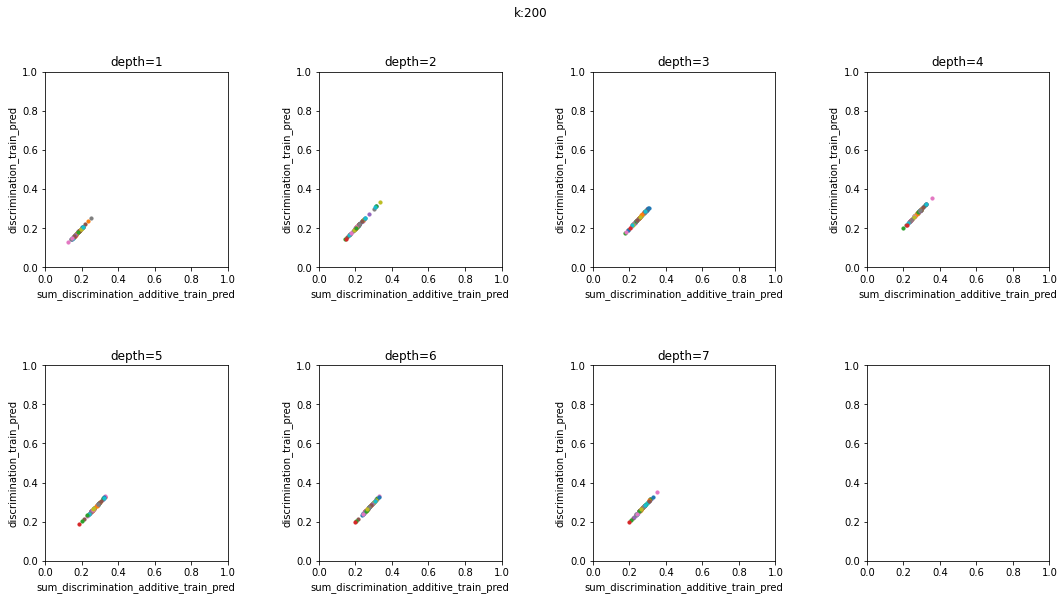

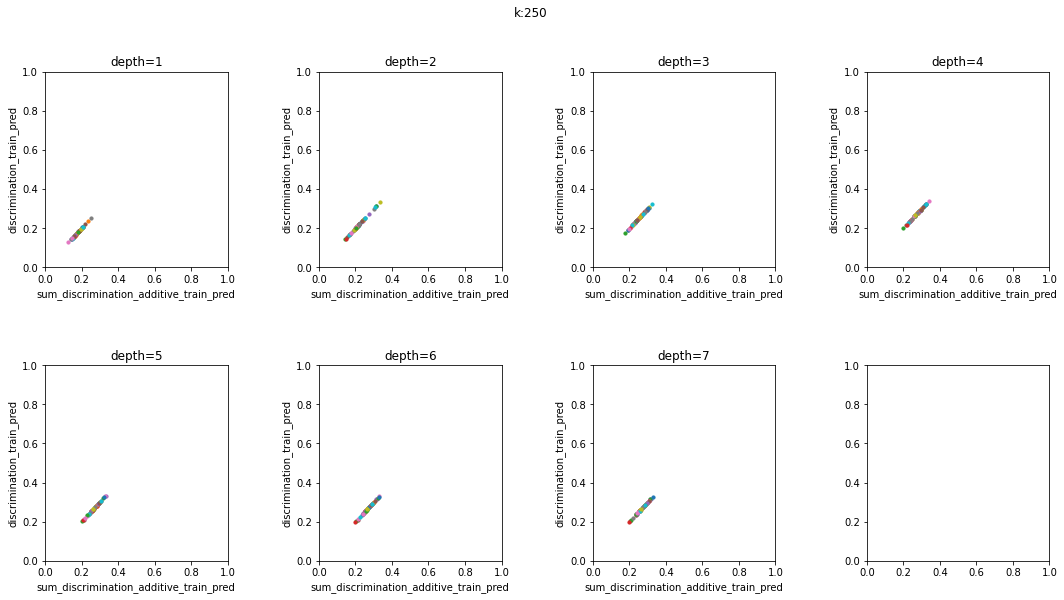

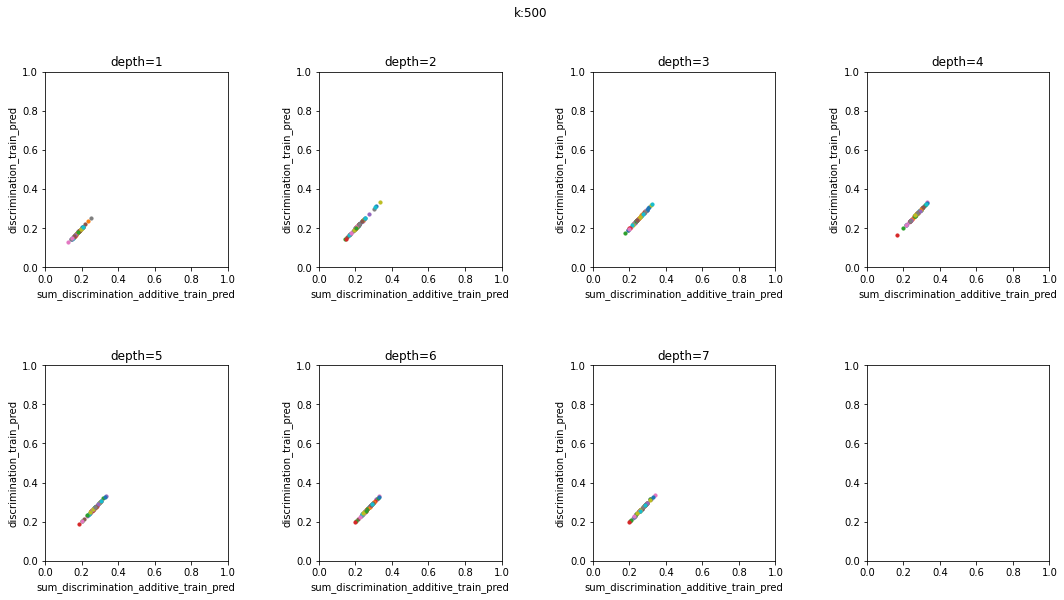

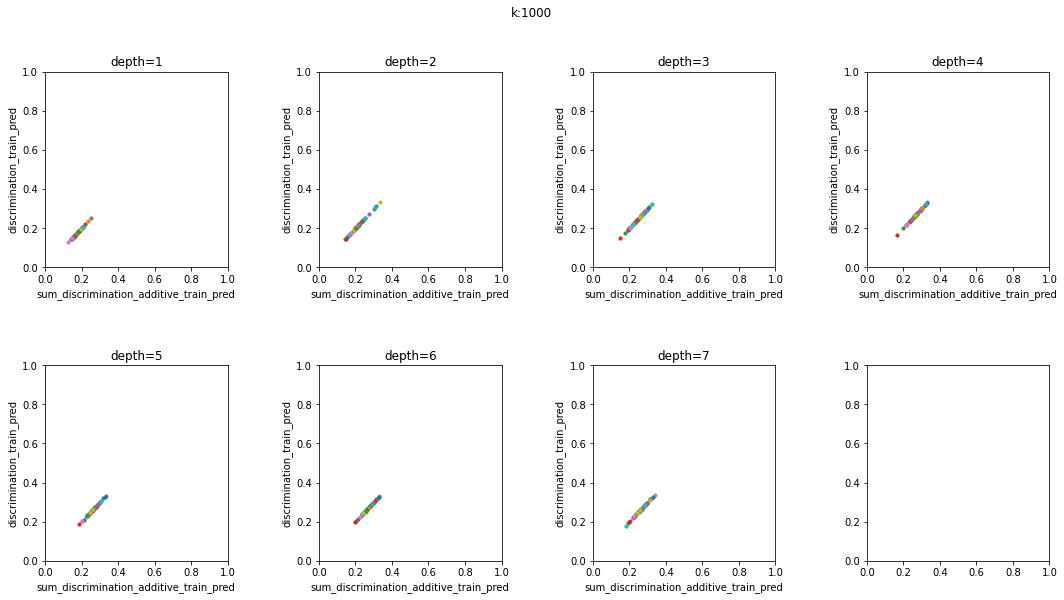

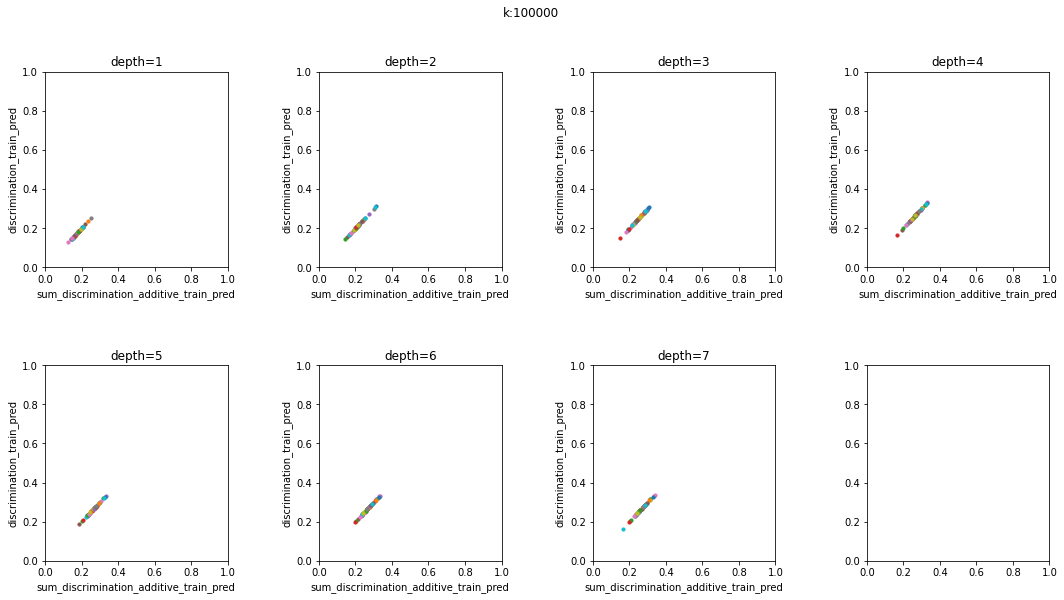

In [16]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, (0, 1), (0, 1))

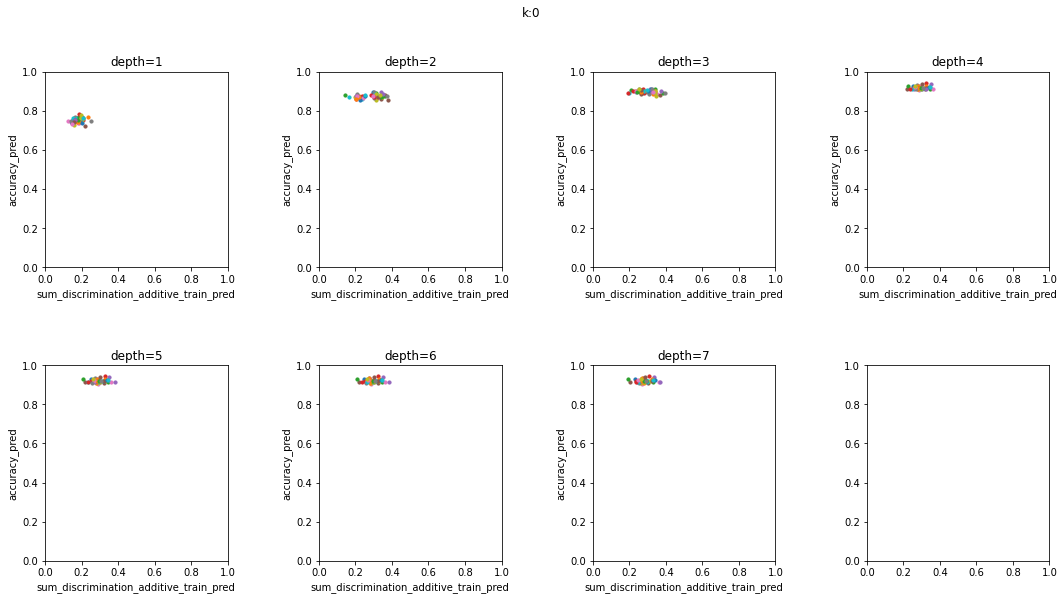

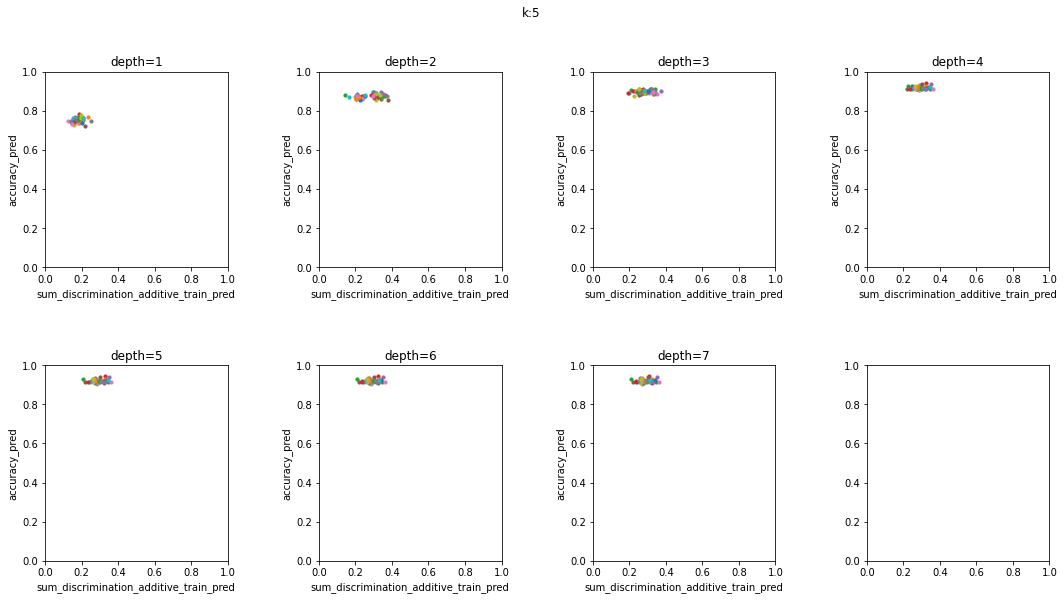

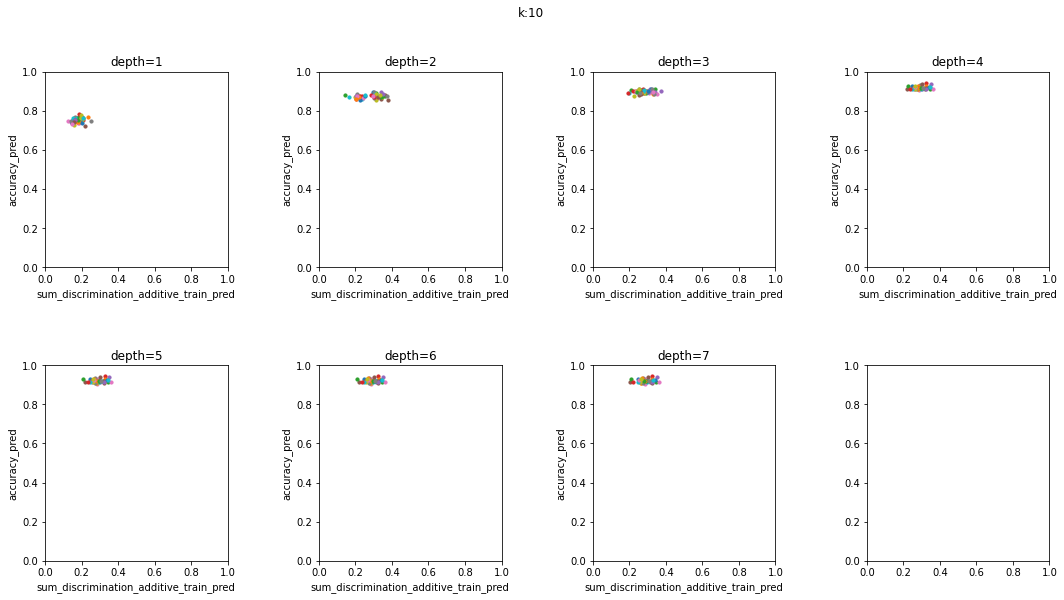

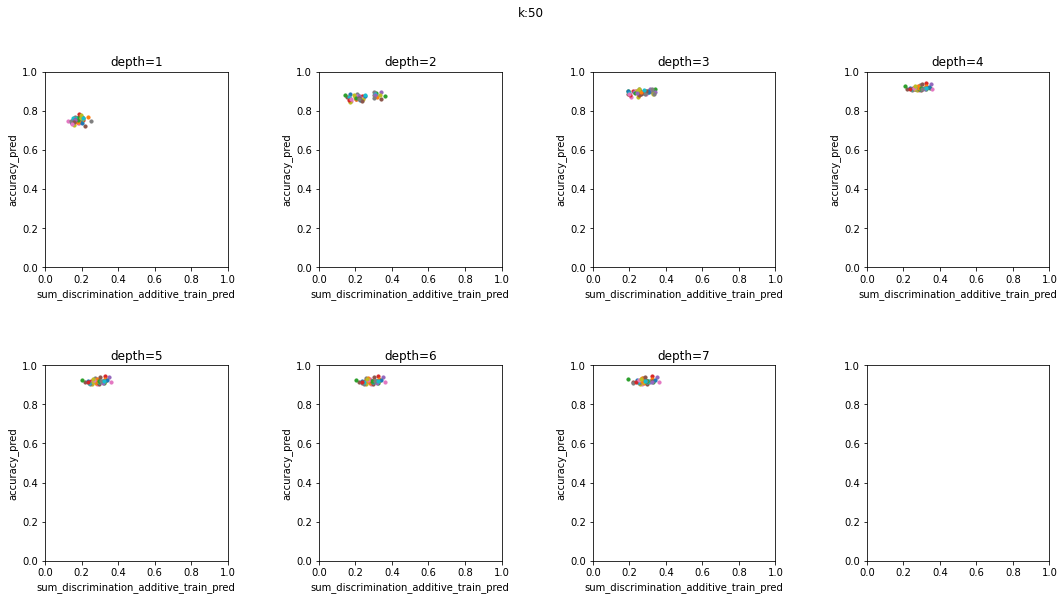

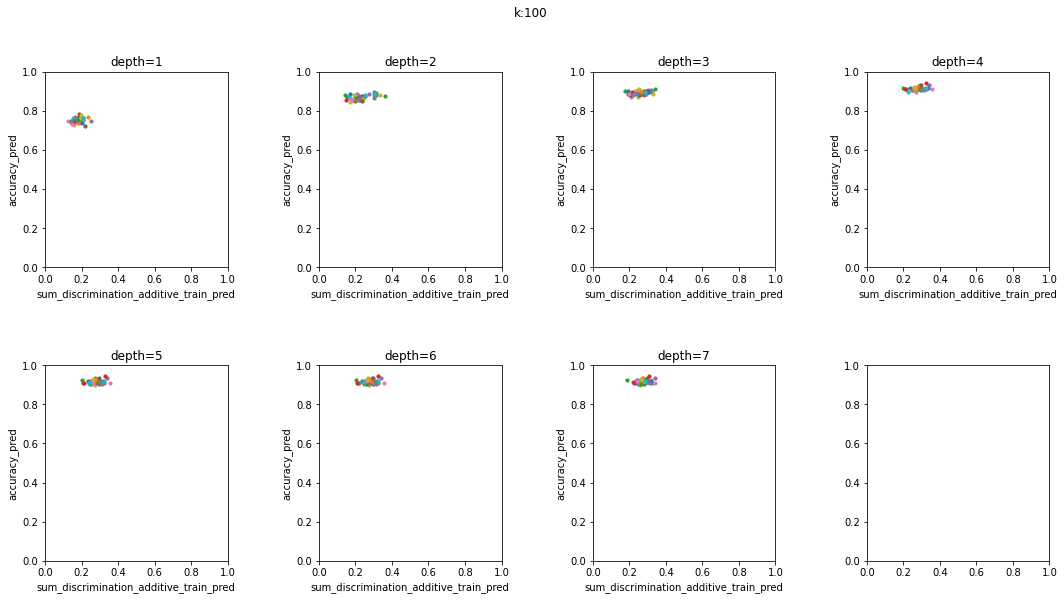

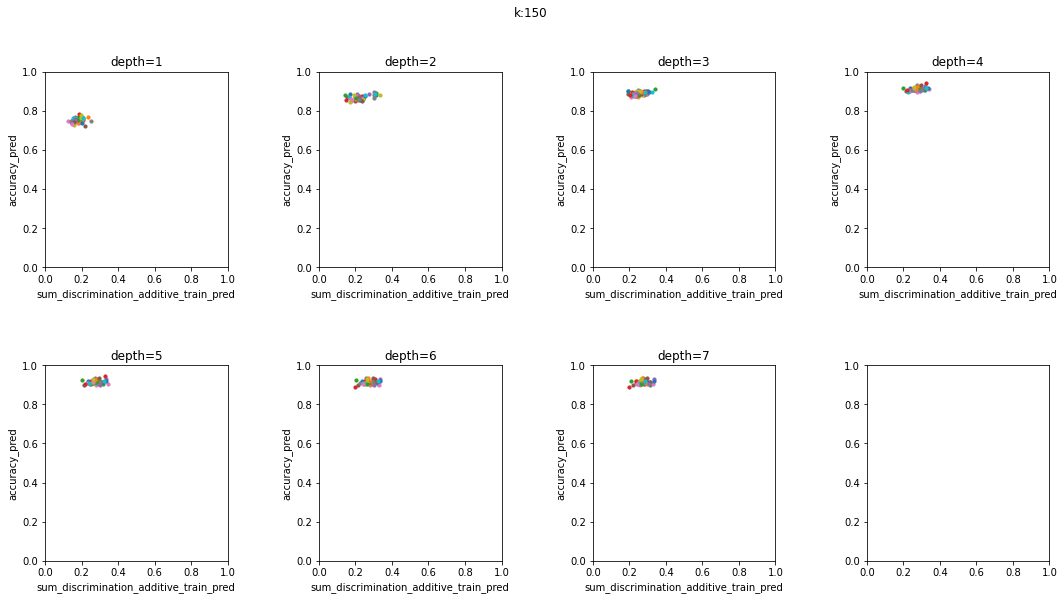

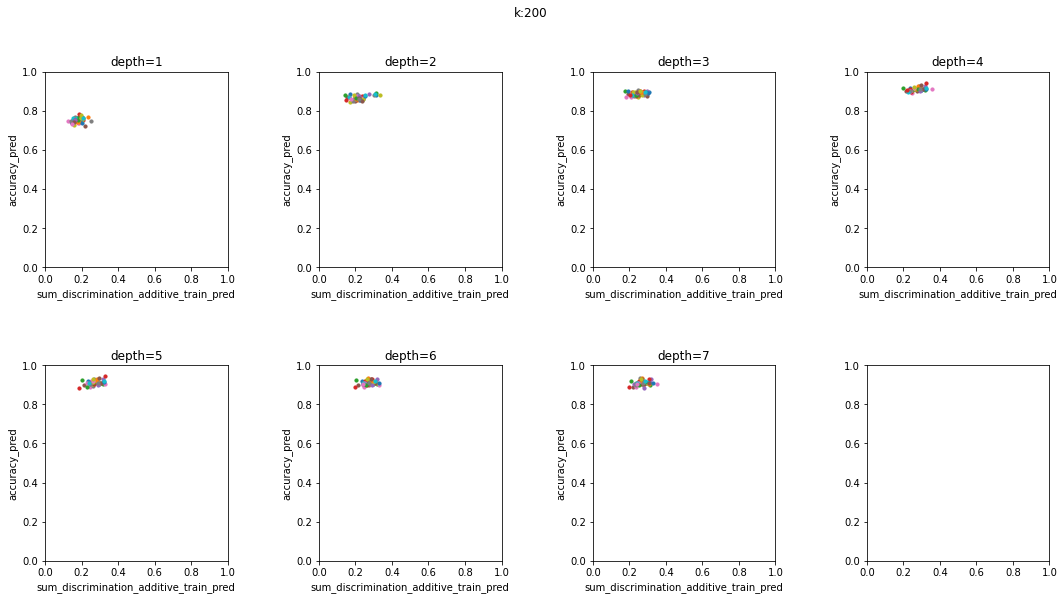

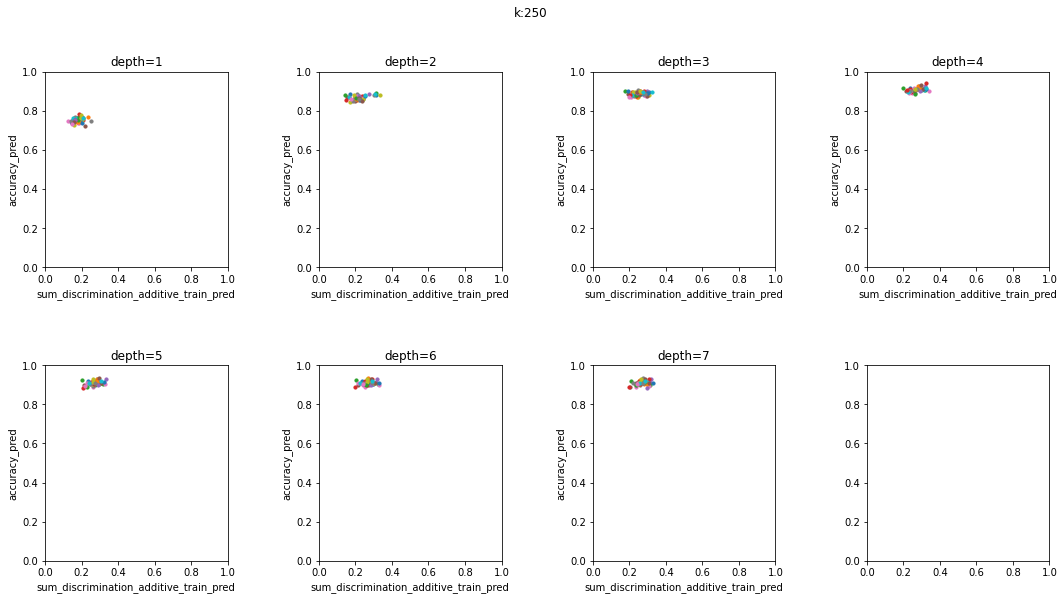

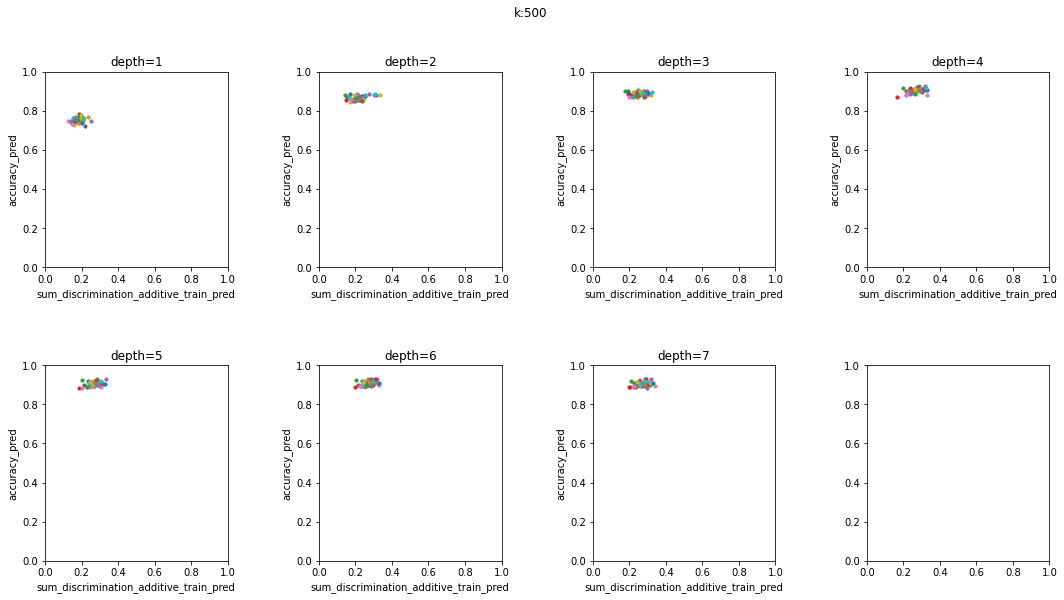

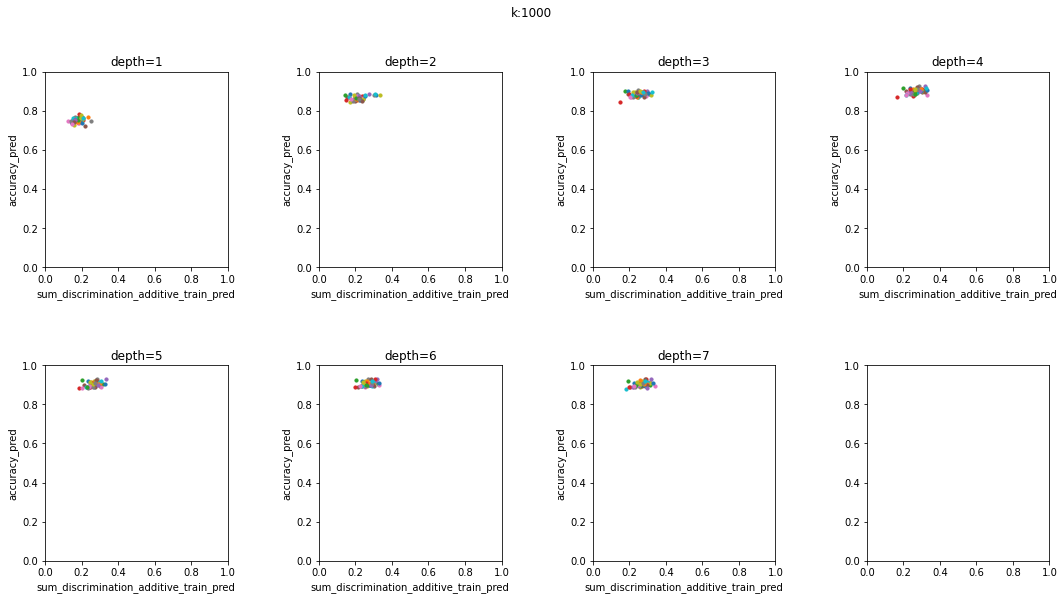

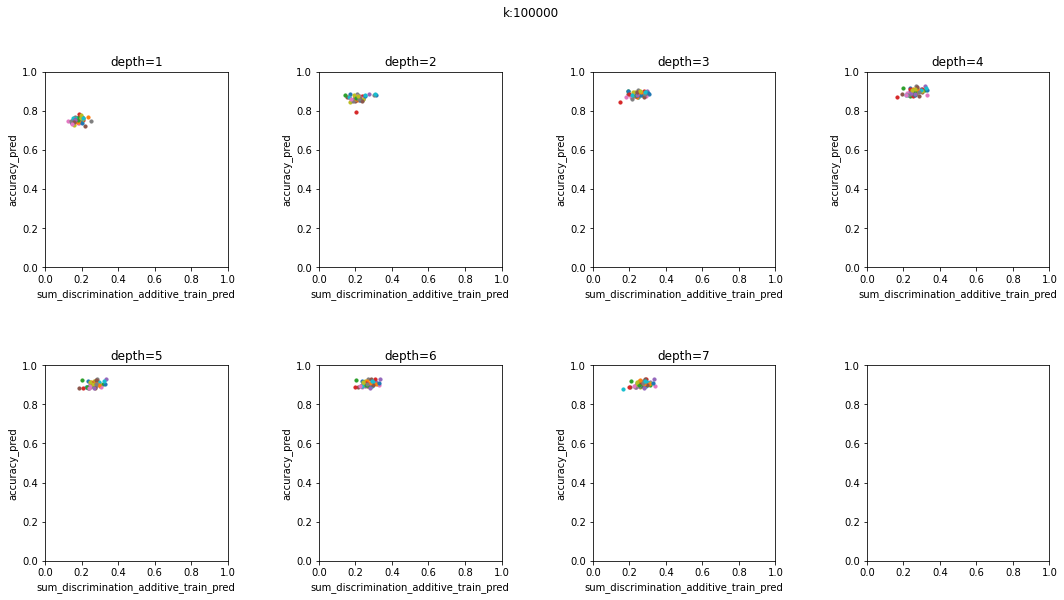

In [17]:
utils.plot_one_scatter_by_depth("sum_discrimination_additive_train_pred", "accuracy_pred", result, (0, 1), (0, 1))

<Figure size 648x432 with 0 Axes>

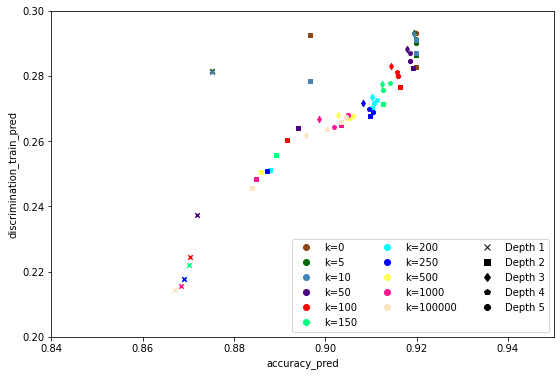

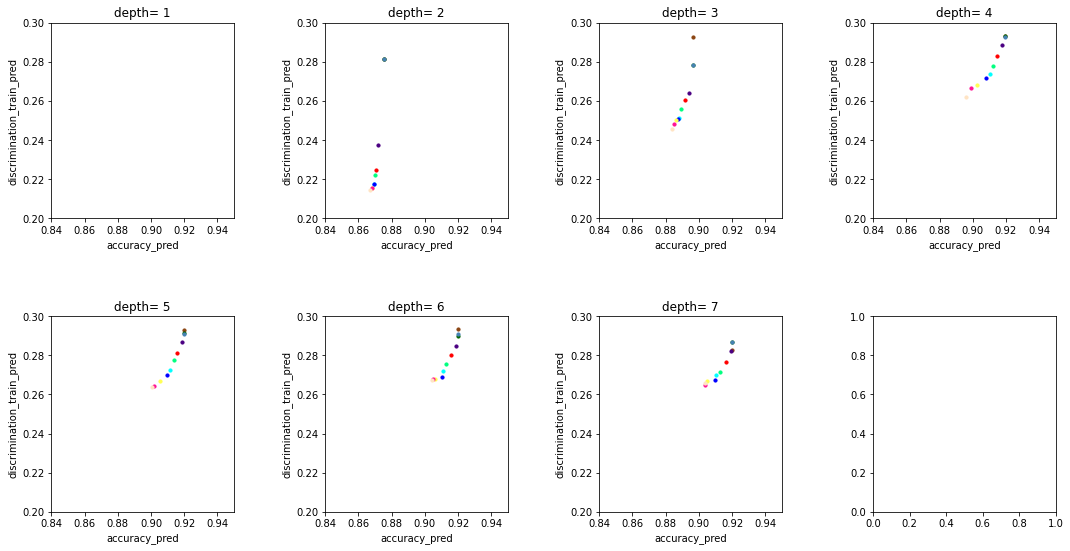

In [18]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_pred", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

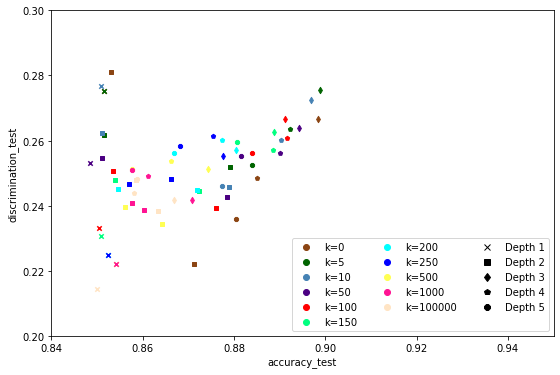

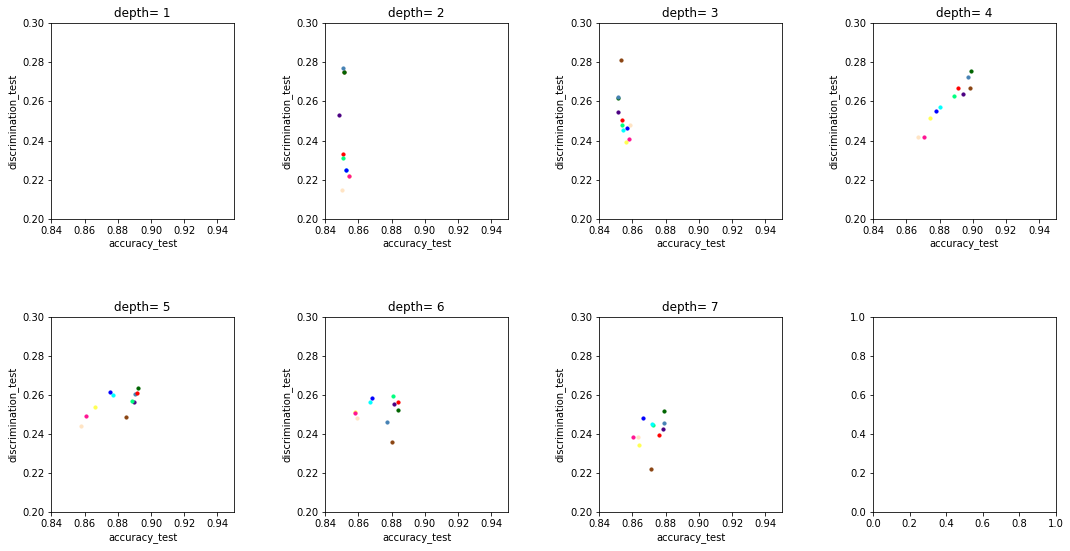

In [19]:
x_lim = (0.84, 0.95)
y_lim = (0.2, 0.3)
utils.plot_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("accuracy_test", "discrimination_test", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

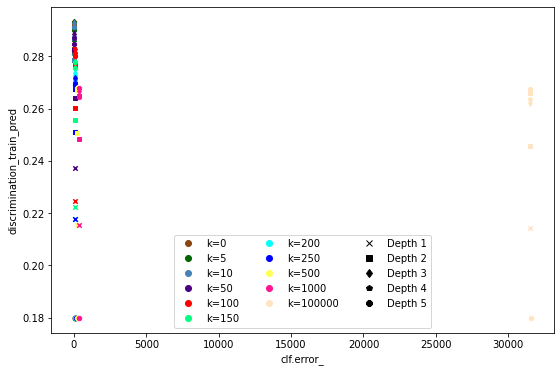

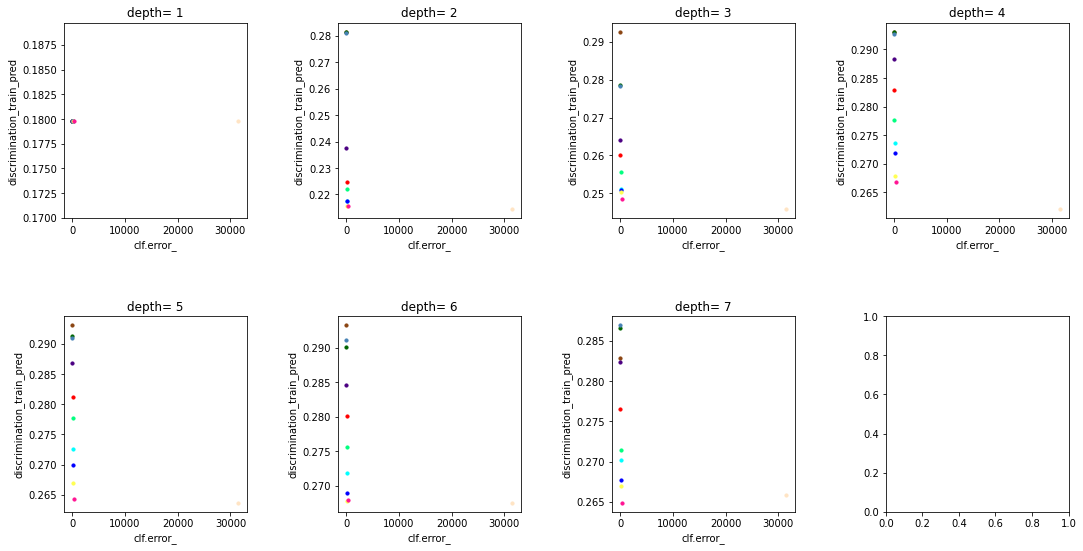

In [20]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("clf.error_", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

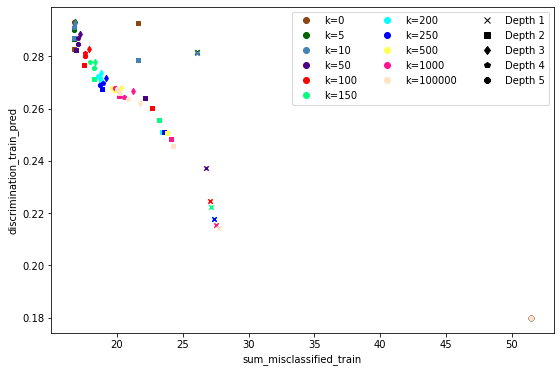

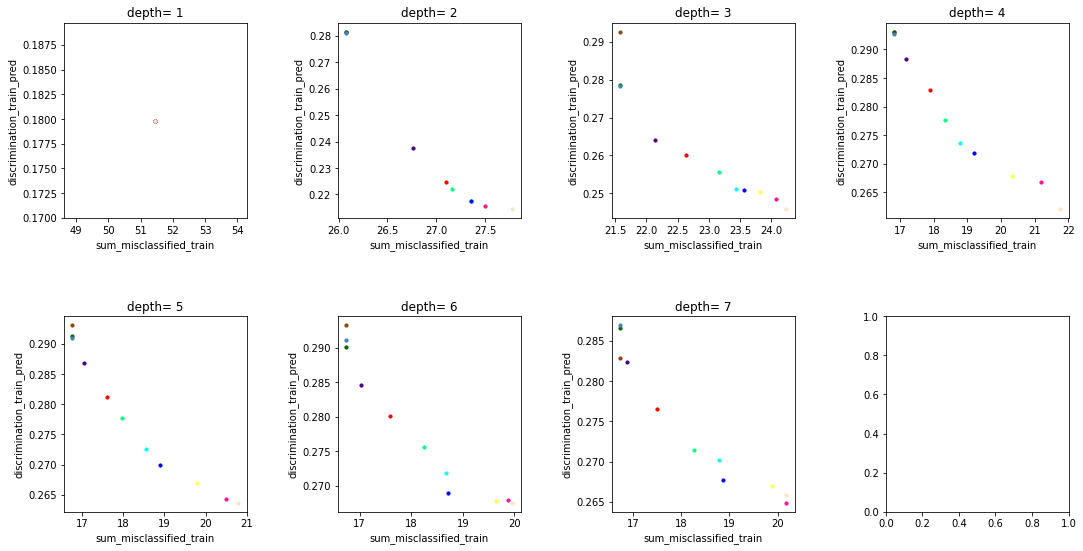

In [21]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

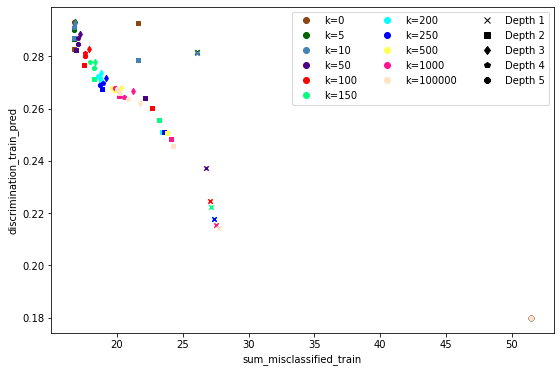

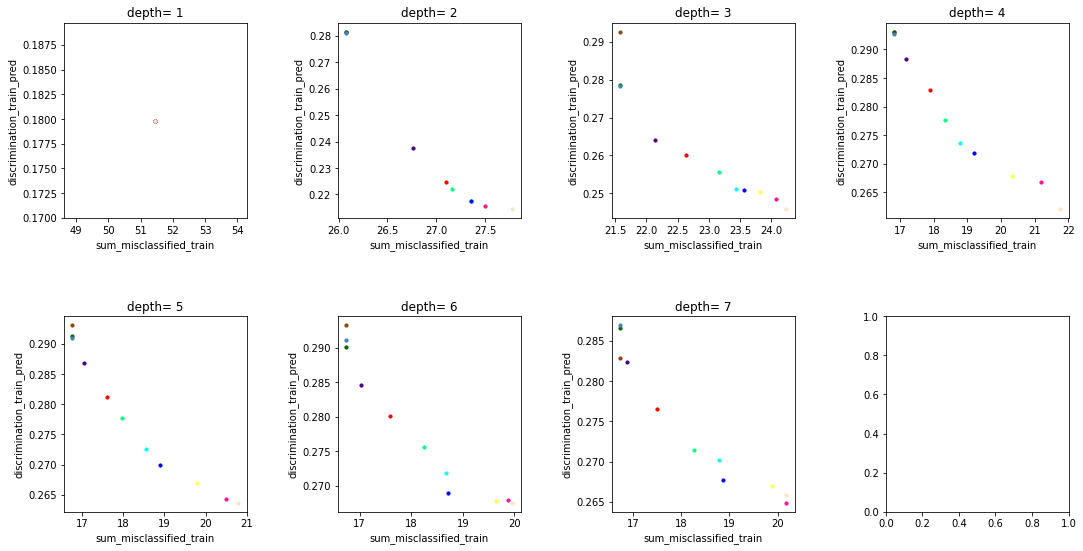

In [22]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_misclassified_train", "discrimination_train_pred", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

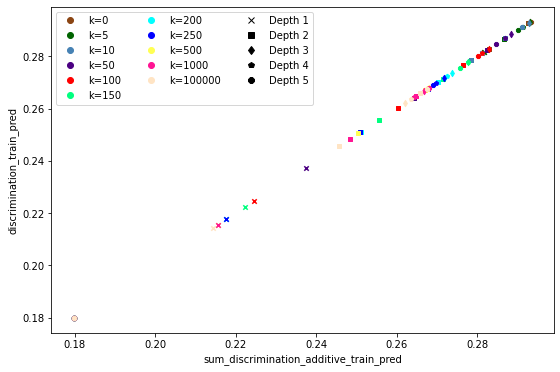

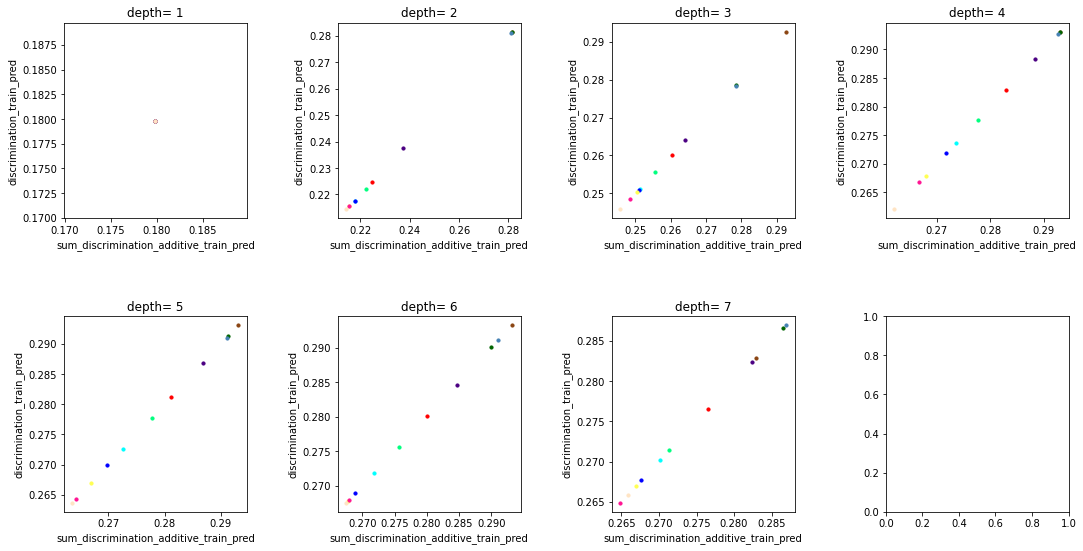

In [23]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "discrimination_train_pred", result, x_lim, y_lim)

In [ ]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)

<Figure size 648x432 with 0 Axes>

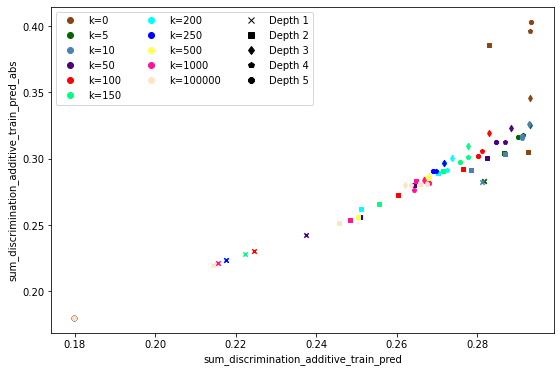

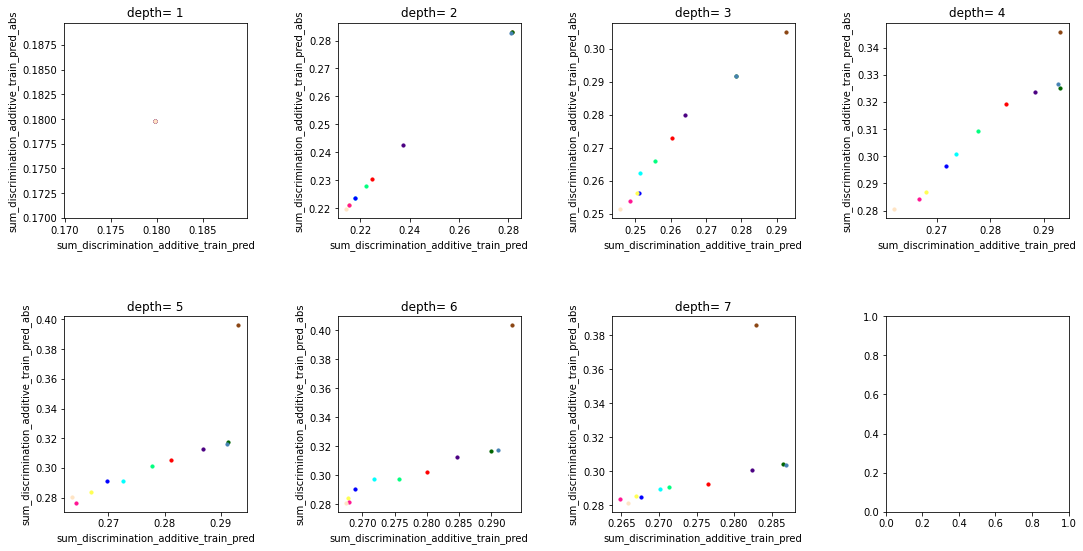

In [24]:
x_lim = None
y_lim = None
utils.plot_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)
utils.plot_each_k_depth_mean("sum_discrimination_additive_train_pred", "sum_discrimination_additive_train_pred_abs", result, x_lim, y_lim)